In [1]:
# @title Celda 1: Configuración, Imports y Conexión a BigQuery

# 1. INSTALACIONES (Descomenta y ejecuta si es necesario para tu Colab)
# Colab suele tener muchas, pero para estar seguro y si cambian de versión
# !pip install pandas google-cloud-bigquery scikit-learn lightgbm numpy toml

# 2. IMPORTS
import os
import json
import logging
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
import datetime # Para manejar fechas

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from lightgbm import LGBMClassifier # Importación específica del clasificador
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# 3. MOCK STREAMLIT PARA COMPATIBILIDAD (No lo borres si este código lo usarás como base para Streamlit en el futuro)
# Simula funciones de Streamlit para que el código que puede venir de una app de Streamlit funcione aquí sin errores.
class MockStreamlit:
    def cache_data(self, func=None, ttl=None):
        if func is None:
            return lambda f: f # Decorador llamado sin paréntesis
        return func
    def cache_resource(self, func=None):
        if func is None:
            return lambda f: f
        return func
    def warning(self, msg): print(f"WARNING (Streamlit Mock): {msg}")
    def info(self, msg): print(f"INFO (Streamlit Mock): {msg}")
    def error(self, msg): print(f"ERROR (Streamlit Mock): {msg}")
    def write(self, *args): print(*args) # Para debug de st.write
    def stop(self): print("Streamlit Mock: st.stop() llamado. Ejecución simulada detenida.")
st = MockStreamlit()


# 4. CONFIGURACIÓN BÁSICA DE LOGGING (solo print para Colab)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# 5. CONSTANTES DEL PROYECTO (¡¡¡ADAPTA ESTO!!!)
GCP_PROJECT_ID = 'pokemon-cards-project' # <-- REEMPLAZA con tu Project ID de BigQuery
BIGQUERY_DATASET = "pokemon_dataset"
CARD_METADATA_TABLE = f"{GCP_PROJECT_ID}.{BIGQUERY_DATASET}.card_metadata"


# 6. RUTAS PARA MODELOS Y PREPROCESADORES (¡¡¡ADAPTA ESTO!!! Montar Drive es crucial si esta es tu ruta real)
# Esta es la base donde están/irán TUS ARCHIVOS DE MODELO y PREPROCESADORES.
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_MOUNTED_PATH = '/content/drive/MyDrive/'
    print("Google Drive montado en /content/drive/MyDrive/.")
except Exception as e:
    logger.warning(f"No se pudo montar Google Drive: {e}. Asumiendo ruta local '.'")
    DRIVE_MOUNTED_PATH = './' # Fallback a directorio actual de Colab si Drive no se monta
    # Crea una carpeta 'model_files' en el directorio actual si no se monta Drive y no existe
    if not os.path.exists('model_files'): os.makedirs('model_files')
    print("WARNING: Operando en directorio local. Asegúrate que los modelos estén aquí o en 'model_files/'.")

# Subcarpeta para guardar los modelos del clasificador
# Se guardarán dentro de la carpeta 'mlp_v1' como subdirectorio
DRIVE_MODEL_BASE_PATH = os.path.join(DRIVE_MOUNTED_PATH, 'Proyecto API', 'RedNeuronal', 'mlp_v1') # <-- VERIFICA ESTA RUTA BASE
CLASSIFIER_MODELS_PATH = os.path.join(DRIVE_MODEL_BASE_PATH, 'classifier_models')
os.makedirs(CLASSIFIER_MODELS_PATH, exist_ok=True)
print(f"Los modelos del clasificador se guardarán en: {CLASSIFIER_MODELS_PATH}")


# 7. CONEXIÓN A BIGQUERY (Usa tu método preferido en Colab)
@st.cache_resource # Esto simula la caché de Streamlit para la conexión
def connect_to_bigquery_colab_fn():
    try:
        from google.colab import auth
        auth.authenticate_user() # Esto abre una ventana de autorización si no estás ya autenticado
        client = bigquery.Client(project=GCP_PROJECT_ID)
        logger.info("BigQuery Client: Conectado vía Colab Auth.")
        return client
    except Exception as e_colab:
        logger.error(f"BigQuery Client: Fallo de autenticación Colab: {e_colab}", exc_info=True)
        print("ERROR: Fallo de autenticación BigQuery. ¿Has ejecutado 'auth.authenticate_user()' y autorizado correctamente?")
        print("Opcional: Si usas Service Account JSON, súbelo a Files y configura 'service_account_file'.")
        # --- Si necesitas autenticación con Service Account JSON File en Colab, descomenta y ajusta ---
        # try:
        #     # Asume que tu service_account.json está subido a los Files de Colab
        #     path_to_service_account_json = 'your_service_account.json' # <-- CAMBIA ESTO
        #     if os.path.exists(path_to_service_account_json):
        #         creds = service_account.Credentials.from_service_account_file(path_to_service_account_json)
        #         client = bigquery.Client(credentials=creds, project=GCP_PROJECT_ID)
        #         logger.info("BigQuery Client: Conectado vía Service Account.")
        #         return client
        #     else:
        #         print(f"WARNING: Service Account JSON no encontrado en '{path_to_service_account_json}'.")
        #         return None
        # except Exception as se_json:
        #     logger.error(f"BigQuery Client: Error en autenticación por Service Account JSON: {se_json}", exc_info=True)
        return None # Devuelve None si todas las autenticaciones fallan

bq_client = connect_to_bigquery_colab_fn()
if bq_client is None:
    raise Exception("ERROR FATAL: No se pudo conectar a Google BigQuery. Por favor, revisa tus credenciales.")

print("\nCelda 1 Finalizada. ¡Continuar con la Celda 2!")

Mounted at /content/drive
Google Drive montado en /content/drive/MyDrive/.
Los modelos del clasificador se guardarán en: /content/drive/MyDrive/Proyecto API/RedNeuronal/mlp_v1/classifier_models

Celda 1 Finalizada. ¡Continuar con la Celda 2!


In [2]:
# @title Celda 2: Carga y Preparación del Dataset de Entrenamiento

# 8. FUNCIONES UTILITARIAS PARA CARGAR DATOS DE BIGQUERY (Copiadas de tu app.py)
# Las decoramos con @st.cache_data para que se parezcan a tu app, aunque aquí solo es un passthrough
# para la función real sin persistencia en disco de caché en Colab (a menos que uses tu propia cache)
@st.cache_data(ttl=3600) # ttl=3600 es para que Streamlit sepa, no afecta este notebook sin un disco de caché.
def get_latest_snapshot_info(_client: bigquery.Client) -> tuple[str | None, pd.Timestamp | None]:
    query = f"SELECT table_id FROM `{_client.project}.{BIGQUERY_DATASET}`.__TABLES__ WHERE STARTS_WITH(table_id, 'monthly_') ORDER BY table_id DESC LIMIT 1"
    try:
        results = _client.query(query).result()
        if results.total_rows > 0:
            latest_table_id_str = list(results)[0].table_id
            full_table_path = f"{_client.project}.{BIGQUERY_DATASET}.{latest_table_id_str}"
            date_str_from_suffix = latest_table_id_str.replace("monthly_", "")
            snapshot_date = pd.to_datetime(date_str_from_suffix, format='%Y_%m_%d')
            logger.info(f"SNAPSHOT_INFO: Usando tabla: {full_table_path}, Fecha Snapshot: {snapshot_date.date()}")
            return full_table_path, snapshot_date
        logger.warning("SNAPSHOT_TABLE: No se encontraron tablas snapshot 'monthly_...'.")
        return None, None
    except Exception as e:
        logger.error(f"SNAPSHOT_TABLE: Error: {e}", exc_info=True)
        print(f"Error crítico al obtener información del último snapshot: {e}")
        return None, None # Asegurarse de siempre devolver una tupla en caso de error

POKEMON_SUFFIXES_TO_REMOVE = [' VMAX', ' VSTAR', ' V-UNION', ' V', ' GX', ' EX', ' BREAK', ' Prism Star', ' Star', ' Radiant', ' δ', ' Tag Team', ' & ', ' Light', ' Dark', ' ◇', ' ☆']
MULTI_WORD_BASE_NAMES = ["Mr. Mime", "Mime Jr.", "Farfetch'd", "Sirfetch'd", "Ho-Oh", "Porygon-Z", "Type: Null", "Tapu Koko", "Tapu Lele", "Tapu Bulu", "Tapu Fini", "Mr. Rime", "Indeedee M", "Indeedee F", "Great Tusk", "Iron Treads"]

def get_true_base_name(name_str, supertype, suffixes, multi_word_bases):
    if not isinstance(name_str, str) or supertype != 'Pokémon': return name_str
    for mw_base in multi_word_bases:
        if name_str.startswith(mw_base): return mw_base
    cleaned_name = name_str
    for suffix in suffixes:
        if cleaned_name.endswith(suffix): cleaned_name = cleaned_name[:-len(suffix)].strip()
    return cleaned_name if cleaned_name else name_str

@st.cache_data(ttl=3600)
def get_card_metadata_with_aliases_fn(_client: bigquery.Client) -> pd.DataFrame:
    # Trae name/artist y sus alias pokemon_name/artist_name
    query = f"""
    SELECT
        id, name, name AS pokemon_name,
        supertype, subtypes, types,
        rarity, set_id, set_name,
        artist, artist AS artist_name,
        images_large AS image_url,
        cardmarket_url, tcgplayer_url
    FROM `{CARD_METADATA_TABLE}`
    """
    logger.info(f"METADATA_BQ: Ejecutando query para metadatos: {query[:100]}...")
    try:
        df = _client.query(query).to_dataframe()
        if df.empty: logger.warning("METADATA_BQ: DataFrame de metadatos vacío."); return pd.DataFrame()
        expected_cols = ['id', 'name', 'pokemon_name', 'artist', 'artist_name', 'supertype', 'subtypes', 'types', 'rarity', 'set_id', 'set_name', 'image_url', 'cardmarket_url', 'tcgplayer_url']
        for col in expected_cols:
            if col not in df.columns:
                # Intenta crear aliases si existen las columnas base
                if col == 'pokemon_name' and 'name' in df.columns: df['pokemon_name'] = df['name']
                elif col == 'artist_name' and 'artist' in df.columns: df['artist_name'] = df['artist']
                else:
                    df[col] = 'Unknown_Placeholder' # Por defecto para columnas que no vienen ni se aliasan
                    logger.warning(f"METADATA_BQ: Columna '{col}' no encontrada ni en la query ni como alias. Placeholder añadido.")

        df['base_pokemon_name_display'] = df.apply(lambda row: get_true_base_name(row['name'], row['supertype'], POKEMON_SUFFIXES_TO_REMOVE, MULTI_WORD_BASE_NAMES), axis=1)
        logger.info(f"METADATA_BQ: Metadatos cargados y procesados. Total filas: {len(df)}.")
        return df
    except Exception as e:
        logger.error(f"METADATA_BQ: Error: {e}", exc_info=True)
        print(f"Error al cargar metadatos de BigQuery: {e}")
        return pd.DataFrame()

def get_price_data_for_training_fn(_client: bigquery.Client, full_table_path: str) -> pd.DataFrame:
    query = f"""
    SELECT
        id, cm_averageSellPrice AS price
    FROM `{full_table_path}`
    """
    try:
        df_prices = _client.query(query).to_dataframe()
        df_prices['price'] = pd.to_numeric(df_prices['price'], errors='coerce')
        logger.info(f"PREPARE_PRICES: Datos de precios de '{full_table_path}' cargados: {len(df_prices)} filas.")
        return df_prices
    except Exception as e:
        logger.error(f"PREPARE_PRICES: Error: {e}", exc_info=True)
        print(f"Error al cargar datos de precios: {e}")
        return pd.DataFrame()


# 9. CONSTRUCCIÓN DEL DATASET DE ENTRENAMIENTO COMPLETO PARA CLASIFICADOR
print("\n--- Iniciando construcción del dataset de entrenamiento para el clasificador ---")

latest_table_path, latest_snapshot_date = get_latest_snapshot_info(bq_client)
if not latest_table_path or latest_snapshot_date is None:
    raise Exception("ERROR: No se pudo obtener información del último snapshot para cargar precios. Abortando entrenamiento.")

df_latest_prices = get_price_data_for_training_fn(bq_client, latest_table_path)
if df_latest_prices.empty:
    raise Exception(f"ERROR: No se cargaron precios del último snapshot '{latest_table_path}'. Abortando entrenamiento.")

all_card_metadata_df_colab = get_card_metadata_with_aliases_fn(bq_client) # Usamos la función del notebook para metadatos
if all_card_metadata_df_colab.empty:
    raise Exception("ERROR: No se pudieron cargar metadatos completos para el entrenamiento. Abortando entrenamiento.")


# Lógica para obtener el snapshot previo (t_minus_1)
def get_previous_month_snapshot_path_fn(current_snapshot_date: pd.Timestamp, _client: bigquery.Client) -> str | None:
    first_day_of_current_month = current_snapshot_date.replace(day=1)
    last_day_of_previous_month = first_day_of_current_month - pd.Timedelta(days=1)
    prev_table_suffix = last_day_of_previous_month.strftime('monthly_%Y_%m_%d')
    prev_full_table_path = f"{_client.project}.{BIGQUERY_DATASET}.{prev_table_suffix}"

    # Opcional: verificar si la tabla existe en BQ
    # from google.cloud.bigquery import NotFound
    # try: _client.get_table(prev_full_table_path)
    # except NotFound: logger.warning(f"Tabla previa no encontrada: {prev_full_table_path}"); return None
    return prev_full_table_path

previous_table_path = get_previous_month_snapshot_path_fn(latest_snapshot_date, bq_client)
df_previous_prices = None
if previous_table_path:
    df_previous_prices = get_price_data_for_training_fn(bq_client, previous_table_path)
    if df_previous_prices.empty:
        print(f"WARNING: No se cargaron precios de la tabla previa '{previous_table_path}'.")
else:
    print("WARNING: No se pudo determinar la ruta de la tabla previa o la tabla previa no existe.")


# Unir metadatos y precios
df_train_classifier_data = all_card_metadata_df_colab.merge(
    df_latest_prices.rename(columns={'price': 'price_t0'}), on='id', how='left'
)

if df_previous_prices is not None and not df_previous_prices.empty:
    df_train_classifier_data = df_train_classifier_data.merge(
        df_previous_prices.rename(columns={'price': 'price_t_minus_1'}), on='id', how='left'
    )
    print(f"Unión con precios del snapshot previo completada. Filas: {len(df_train_classifier_data)}")
else:
    print("WARNING: No hay datos de precios previos. La feature 'price_t_minus_1' se rellenará con median.")
    df_train_classifier_data['price_t_minus_1'] = np.nan


# Imputar precios NaN antes de calcular el cambio si es necesario
df_train_classifier_data['price_t0'] = pd.to_numeric(df_train_classifier_data['price_t0'], errors='coerce')
# Imputación para 'price_t_minus_1' que se usa en features numéricas
# Si el precio_t0 también puede ser NaN y se usa la mediana, hay que manejarlo.
median_price_t0_actual = df_train_classifier_data['price_t0'].median()
df_train_classifier_data['price_t_minus_1'] = df_train_classifier_data['price_t_minus_1'].fillna(median_price_t0_actual)
df_train_classifier_data['price_t_minus_1'] = pd.to_numeric(df_train_classifier_data['price_t_minus_1'], errors='coerce')


# Calcular price_change_from_prev
df_train_classifier_data['price_change_from_prev'] = (df_train_classifier_data['price_t0'] - df_train_classifier_data['price_t_minus_1']) / df_train_classifier_data['price_t_minus_1'].replace(0, np.nan)
df_train_classifier_data['price_change_from_prev'] = df_train_classifier_data['price_change_from_prev'].fillna(0) # Si el cambio no se puede calcular, asumir 0

# 11. DEFINICIÓN DE LA VARIABLE OBJETIVO (y)
# Clasificar por precio ACTUAL (price_t0)
BULK_THRESHOLD = 5.0
CHEAP_THRESHOLD = 50.0
EXPENSIVE_THRESHOLD = 200.0

def classify_current_price_category(price: float) -> str:
    if pd.isna(price): return 'Unknown'
    elif price < BULK_THRESHOLD: return 'Bulk'
    elif price < CHEAP_THRESHOLD: return 'Asequible'
    elif price < EXPENSIVE_THRESHOLD: return 'Cara'
    else: return 'Coleccionista'

df_train_classifier_data['price_category_target'] = df_train_classifier_data['price_t0'].apply(classify_current_price_category)

print("\nConteo de categorías de precio para el target (ANTES de filtrar 'Unknown'):")
print(df_train_classifier_data['price_category_target'].value_counts())

df_train_classifier = df_train_classifier_data[df_train_classifier_data['price_category_target'] != 'Unknown'].copy()
if df_train_classifier.empty:
    raise Exception("El DataFrame para entrenamiento de clasificador está vacío después de clasificar precios.")

X_train_features_df = df_train_classifier
y_train_target_series = df_train_classifier['price_category_target']

print(f"\nDatos preparados para clasificador: {len(X_train_features_df)} filas.")
print(f"Conteo de categorías FINAL del target:\n{y_train_target_series.value_counts()}")
print(f"Columnas del DataFrame de features para clasificador: {X_train_features_df.columns.tolist()}")

print("\nCelda 2 Finalizada. ¡Continuar con la Celda 3!")


--- Iniciando construcción del dataset de entrenamiento para el clasificador ---


ERROR:__main__:PREPARE_PRICES: Error: 404 Not found: Table pokemon-cards-project:pokemon_dataset.monthly_2025_03_31 was not found in location US; reason: notFound, message: Not found: Table pokemon-cards-project:pokemon_dataset.monthly_2025_03_31 was not found in location US

Location: US
Job ID: d51c69ca-2a44-4721-8119-1c857a1fcaa9
Traceback (most recent call last):
  File "<ipython-input-2-1b4e3ca8a1d4>", line 79, in get_price_data_for_training_fn
    df_prices = _client.query(query).to_dataframe()
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/job/query.py", line 2074, in to_dataframe
    query_result = wait_for_query(self, progress_bar_type, max_results=max_results)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/_tqdm_helpers.py", line 107, in wait_for_query
    return query_job.result(max_results=max_r

Error al cargar datos de precios: 404 Not found: Table pokemon-cards-project:pokemon_dataset.monthly_2025_03_31 was not found in location US; reason: notFound, message: Not found: Table pokemon-cards-project:pokemon_dataset.monthly_2025_03_31 was not found in location US

Location: US
Job ID: d51c69ca-2a44-4721-8119-1c857a1fcaa9


Conteo de categorías de precio para el target (ANTES de filtrar 'Unknown'):
price_category_target
Bulk             14656
Asequible         3264
Cara               438
Unknown            414
Coleccionista      104
Name: count, dtype: int64

Datos preparados para clasificador: 18462 filas.
Conteo de categorías FINAL del target:
price_category_target
Bulk             14656
Asequible         3264
Cara               438
Coleccionista      104
Name: count, dtype: int64
Columnas del DataFrame de features para clasificador: ['id', 'name', 'pokemon_name', 'supertype', 'subtypes', 'types', 'rarity', 'set_id', 'set_name', 'artist', 'artist_name', 'image_url', 'cardmarke

## 📊 Análisis Exploratorio de Datos (EDA) Detallado para el Clasificador
Este apartado tiene como objetivo fundamental explorar y comprender la estructura, las distribuciones y las relaciones en nuestros datos, lo que permitirá justificar decisiones en el preprocesamiento y la selección de modelos.

--- COMENZANDO EL ANÁLISIS ---

### 1. Vistazo General del Dataset
Exploramos las primeras filas, dimensiones, tipos de datos y un resumen estadístico para entender la naturaleza inicial de los datos.

#### 1.1. Primeras 5 filas del DataFrame:
          id              name      pokemon_name supertype subtypes    types     rarity set_id set_name           artist      artist_name                                         image_url                                     cardmarket_url                                     tcgplayer_url base_pokemon_name_display  price_t0  price_t_minus_1  price_change_from_prev price_category_target
0    base1-1          Alakazam          Alakazam   Pokémon  Stage 2

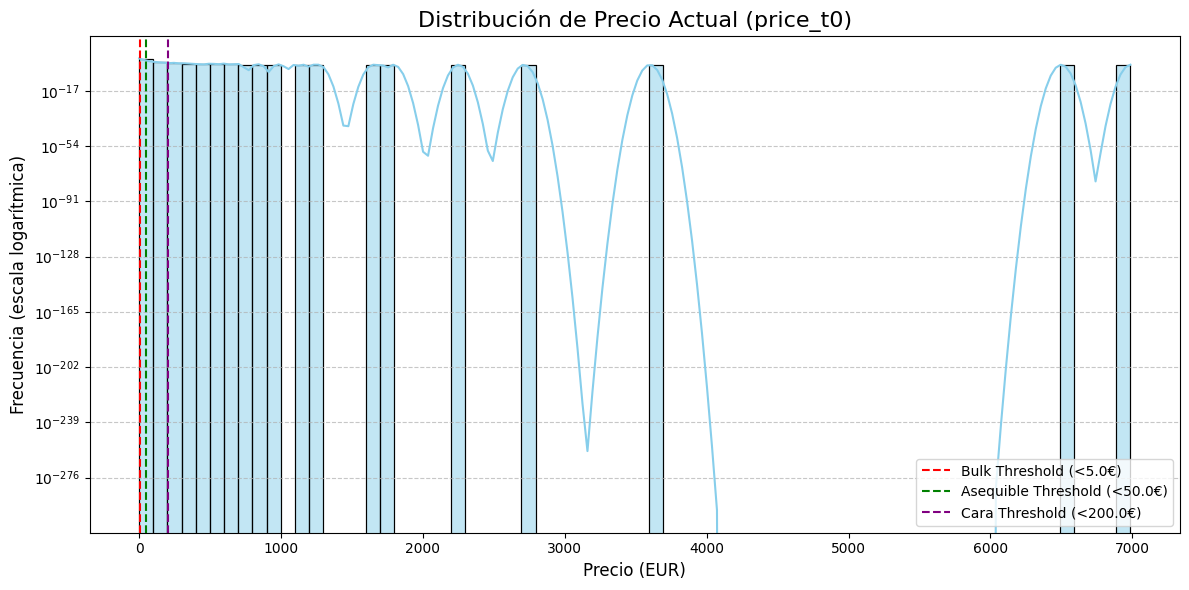

Observación: La distribución de 'price_t0' está fuertemente sesgada a la derecha. La mayoría de las cartas se agrupan en el rango de precios bajos, mientras que una pequeña fracción de cartas son muy caras. La escala logarítmica y los umbrales de clasificación ayudan a visualizar la distribución de los precios subyacentes a cada categoría. Esto subraya la necesidad de categorías discretas para la clasificación, ya que una regresión directa sería compleja.

#### 2.1.2. Distribución de las Categorías de Precio (Variable Target):


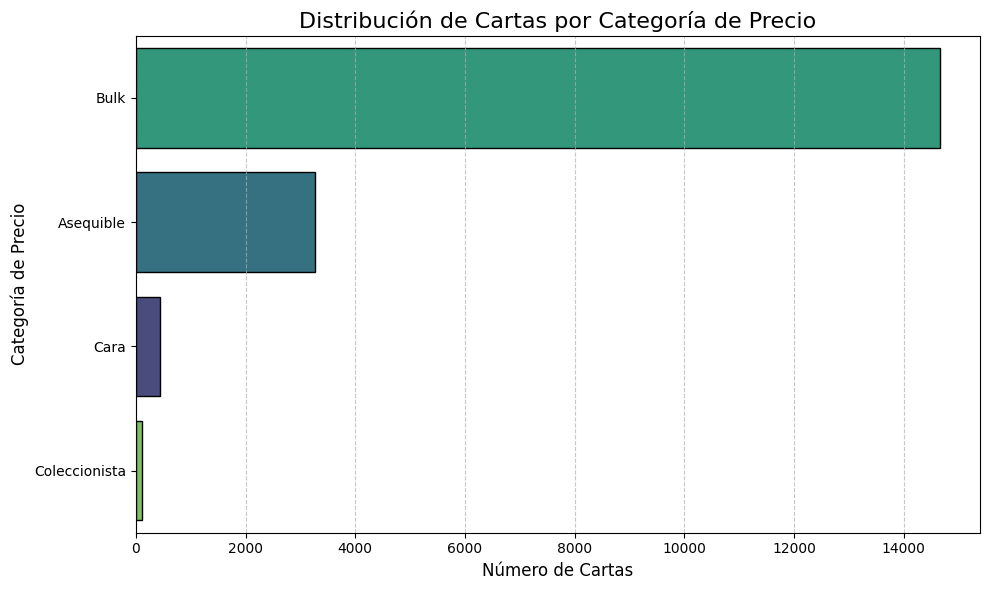


**Conteo absoluto y porcentual por categoría:**
price_category_target
Bulk             14656
Asequible         3264
Cara               438
Coleccionista      104


price_category_target
Bulk             79.38%
Asequible        17.68%
Cara              2.37%
Coleccionista     0.56%

Observación: Se observa un **fuerte desbalance de clases**, con 'Bulk' representando una gran mayoría y 'Coleccionista' una minoría. Esto es un desafío crítico para el modelo de clasificación. El modelo necesitará ser robusto ante clases desequilibradas, y métricas como el F1-score por clase y la matriz de confusión serán más relevantes que el accuracy general.

#### 2.2. Distribución de Características Numéricas ('price_t_minus_1', 'price_change_from_prev'):


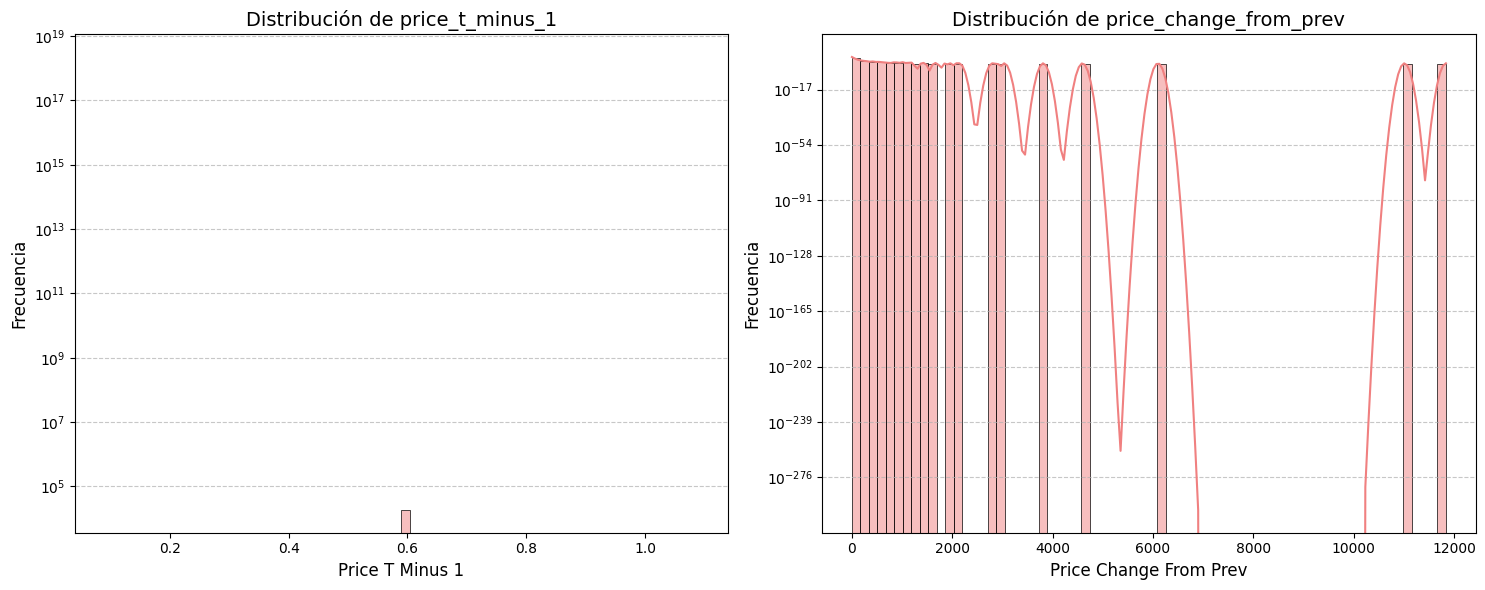

Estadísticas descriptivas detalladas para las columnas numéricas:

--- price_t_minus_1 ---
count    1.846200e+04
mean     5.900000e-01
std      1.114694e-13
min      5.900000e-01
25%      5.900000e-01
50%      5.900000e-01
75%      5.900000e-01
max      5.900000e-01

--- price_change_from_prev ---
count    18462.000000
mean        14.629137
std        154.158795
min         -1.000000
25%         -0.796610
50%          0.000000
75%          4.949153
max      11840.813559

Observación: 'price_t_minus_1' presenta un sesgo similar a 'price_t0', concentrándose en valores bajos. Por otro lado, 'price_change_from_prev' se concentra fuertemente en el valor 0 (lo que significa que la mayoría de las cartas no experimentaron cambio de precio de un mes a otro), con colas ligeras en valores positivos y negativos. El **escalado de estas variables con `StandardScaler` es una acción de preprocesamiento necesaria** para que el modelo no asigne una importancia indebida a las características con rangos m

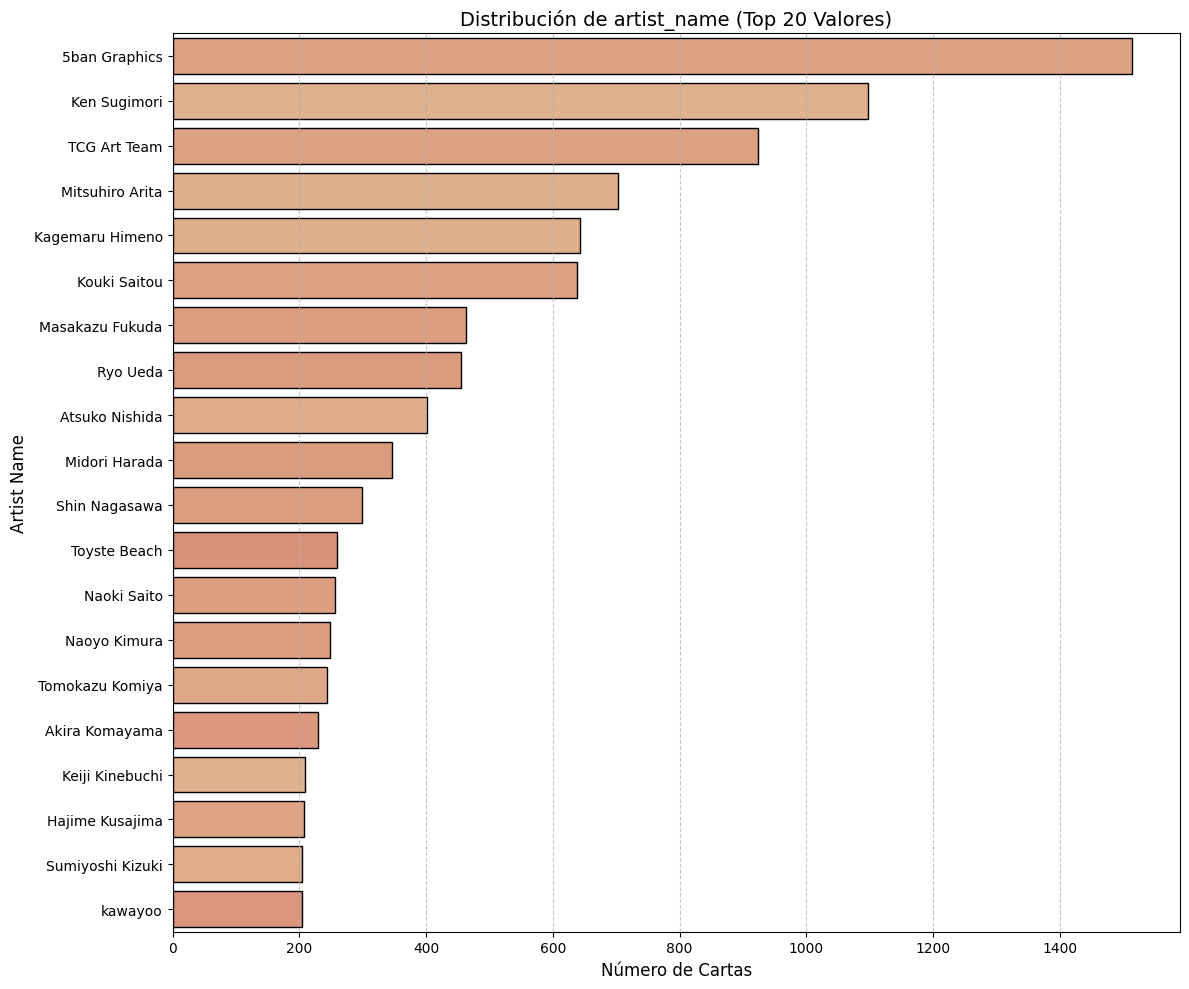


--- Columna: 'pokemon_name' - Número de valores únicos: 4150 ---
**Top 20 valores más frecuentes en 'pokemon_name':**
pokemon_name
Pikachu       94
Eevee         62
Raichu        42
Magnemite     40
Charmander    39
Snorlax       39
Magneton      38
Unown         36
Magikarp      34
Voltorb       33
Electrode     32
Vulpix        31
Ninetales     31
Lapras        31
Meowth        31
Ralts         29
Kirlia        29
Riolu         29
Scyther       29
Gastly        29


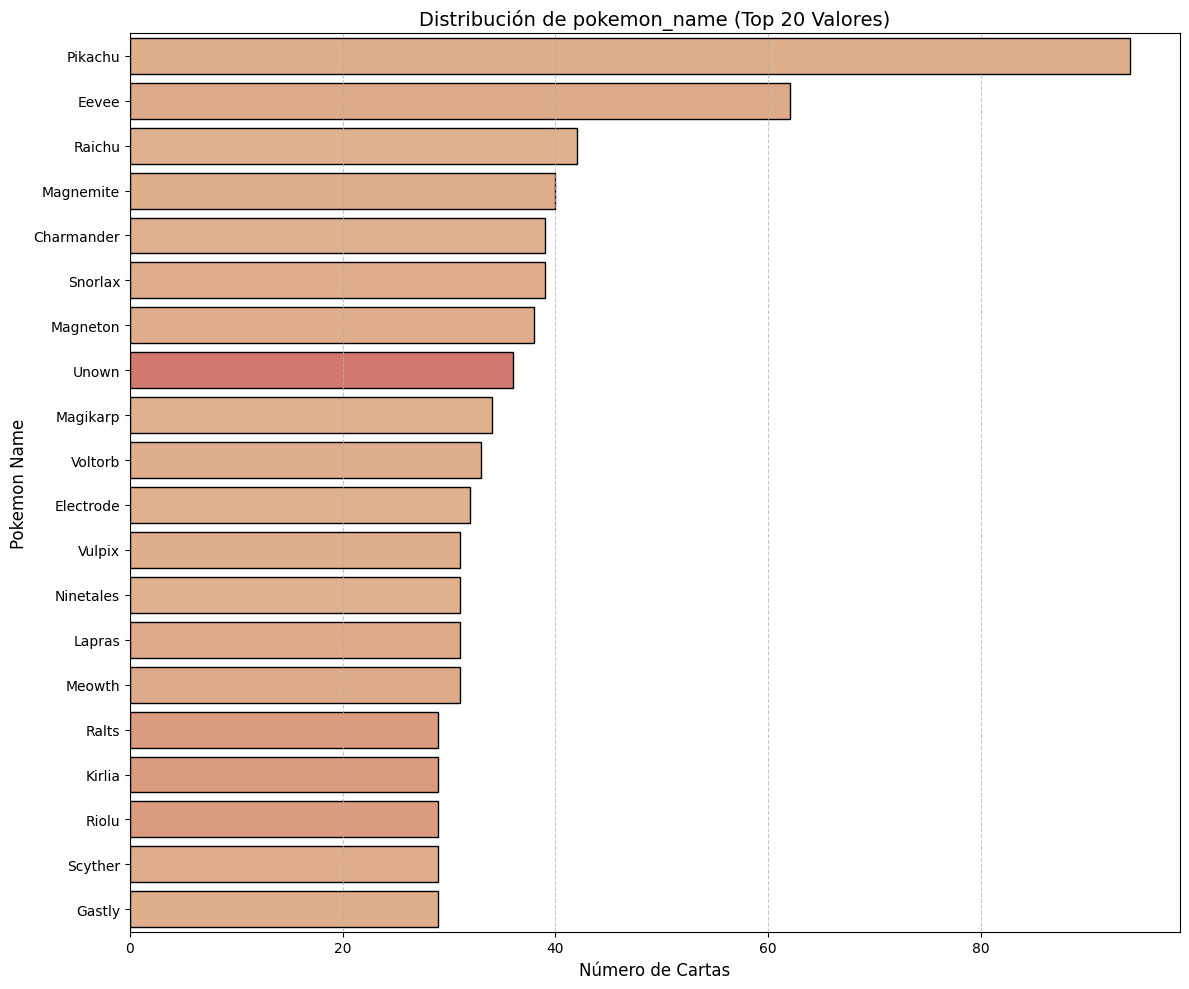


--- Columna: 'rarity' - Número de valores únicos: 34 ---
**Top 20 valores más frecuentes en 'rarity':**
rarity
Common                       4989
Uncommon                     4505
Rare                         2420
Rare Holo                    1617
Promo                        1135
Rare Ultra                    798
Rare Secret                   325
Rare Rainbow                  324
Rare Holo EX                  318
Rare Holo V                   281
Illustration Rare             230
Ultra Rare                    199
Double Rare                   175
Rare Holo GX                  165
Rare Shiny                    149
Shiny Rare                    120
Special Illustration Rare     110
Rare Holo VMAX                110
Trainer Gallery Rare Holo      80
Hyper Rare                     63


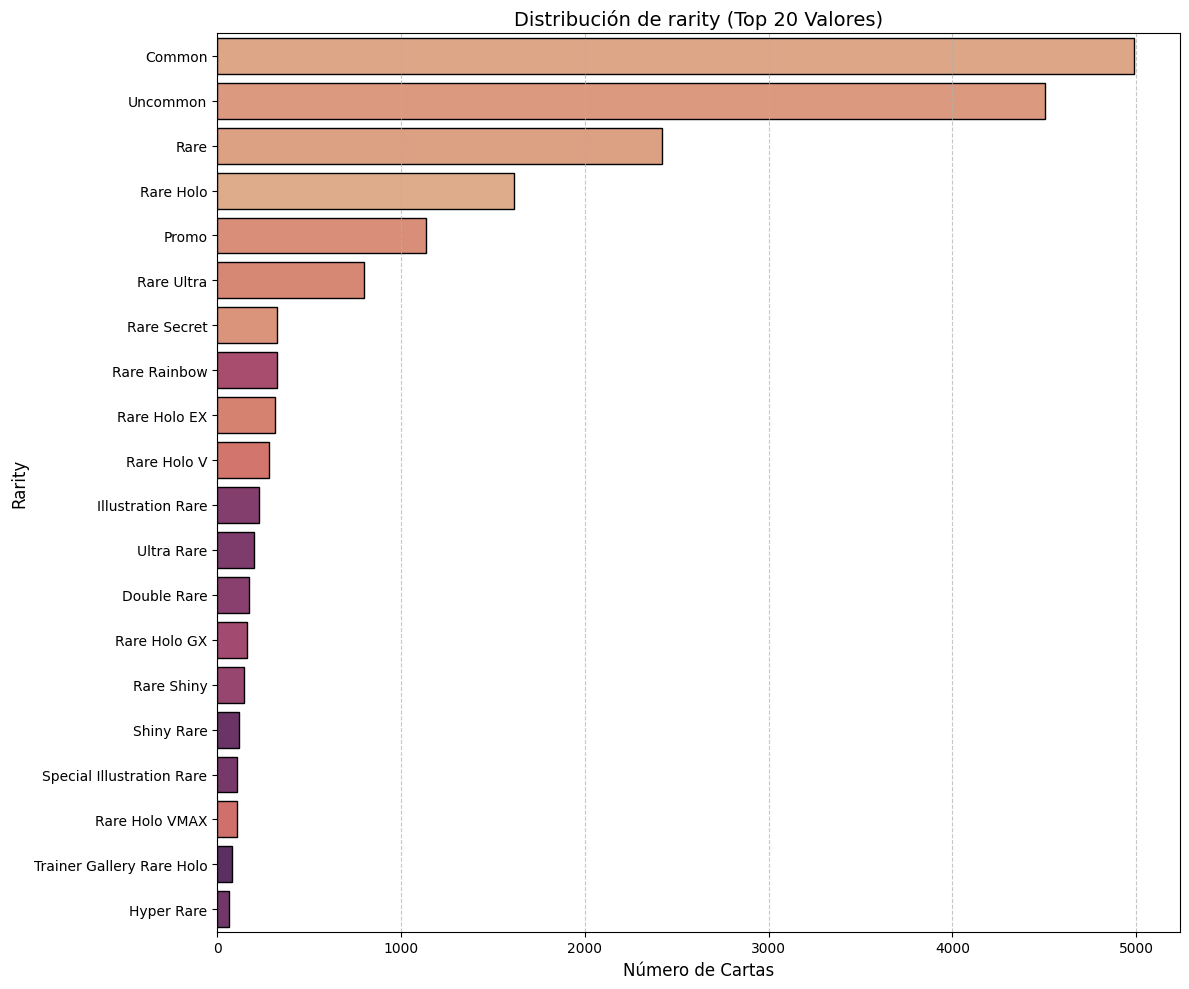


--- Columna: 'set_name' - Número de valores únicos: 152 ---
**Top 20 valores más frecuentes en 'set_name':**
set_name
SWSH Black Star Promos    304
Fusion Strike             284
Paldea Evolved            279
Cosmic Eclipse            272
Paradox Rift              266
Unified Minds             261
Scarlet & Violet          258
Surging Sparks            252
SM Black Star Promos      251
Paldean Fates             245
Lost Thunder              240
Unbroken Bonds            238
Evolving Skies            237
Chilling Reign            233
Obsidian Flames           230
Twilight Masquerade       226
Temporal Forces           218
Lost Origin               217
Astral Radiance           216
Sword & Shield            216


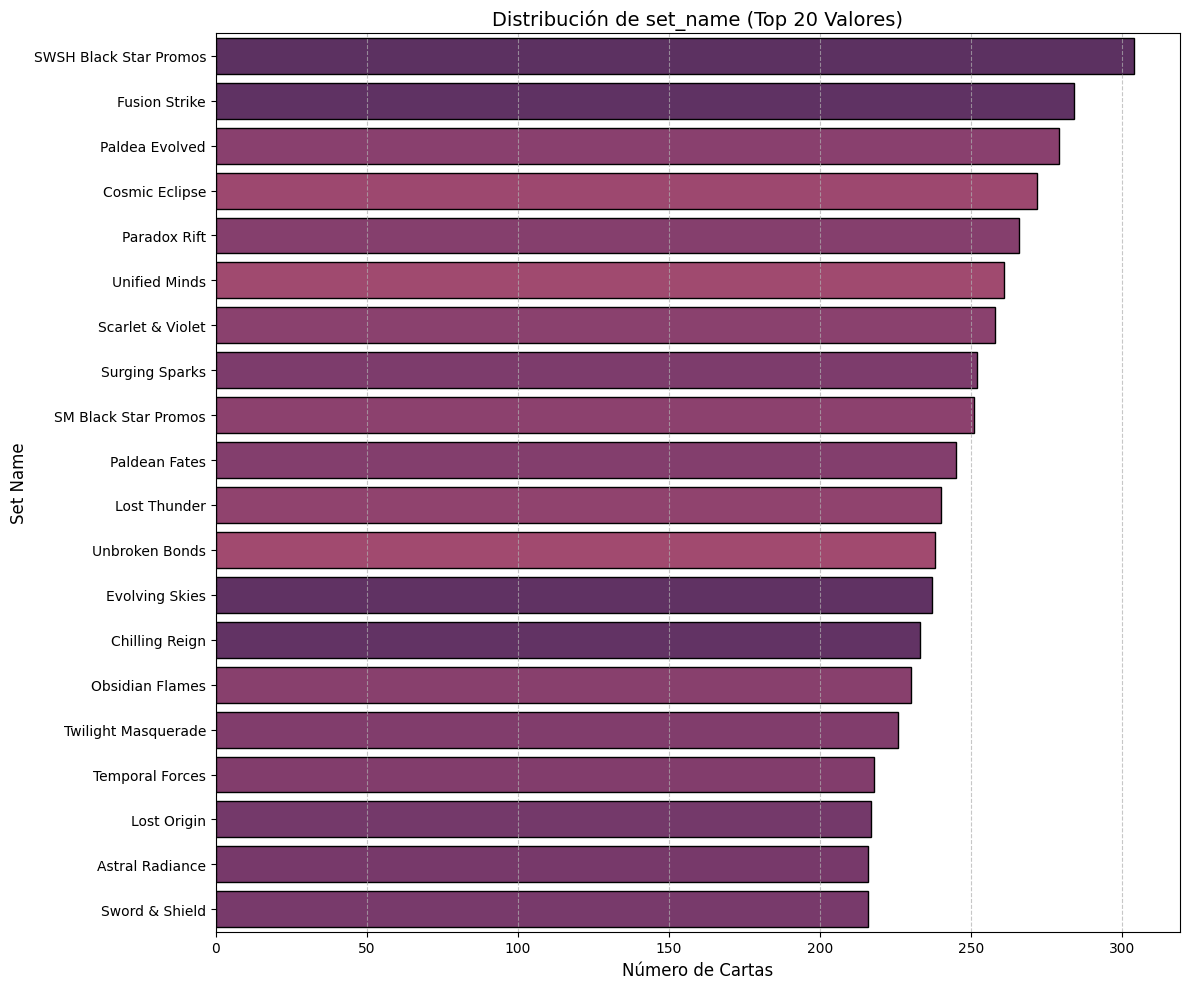


--- Columna: 'types' - Número de valores únicos: 38 ---
**Top 20 valores más frecuentes en 'types':**
types
Trainer               2494
Water                 2219
Grass                 2172
Psychic               2120
Colorless             1978
Fighting              1690
Fire                  1386
Lightning             1363
Darkness              1047
Metal                  829
Dragon                 489
Energy                 344
Fairy                  229
Grass, Darkness         10
Lightning, Metal         9
Fighting, Darkness       8
Water, Metal             7
Darkness, Metal          7
Water, Darkness          7
Fire, Metal              6


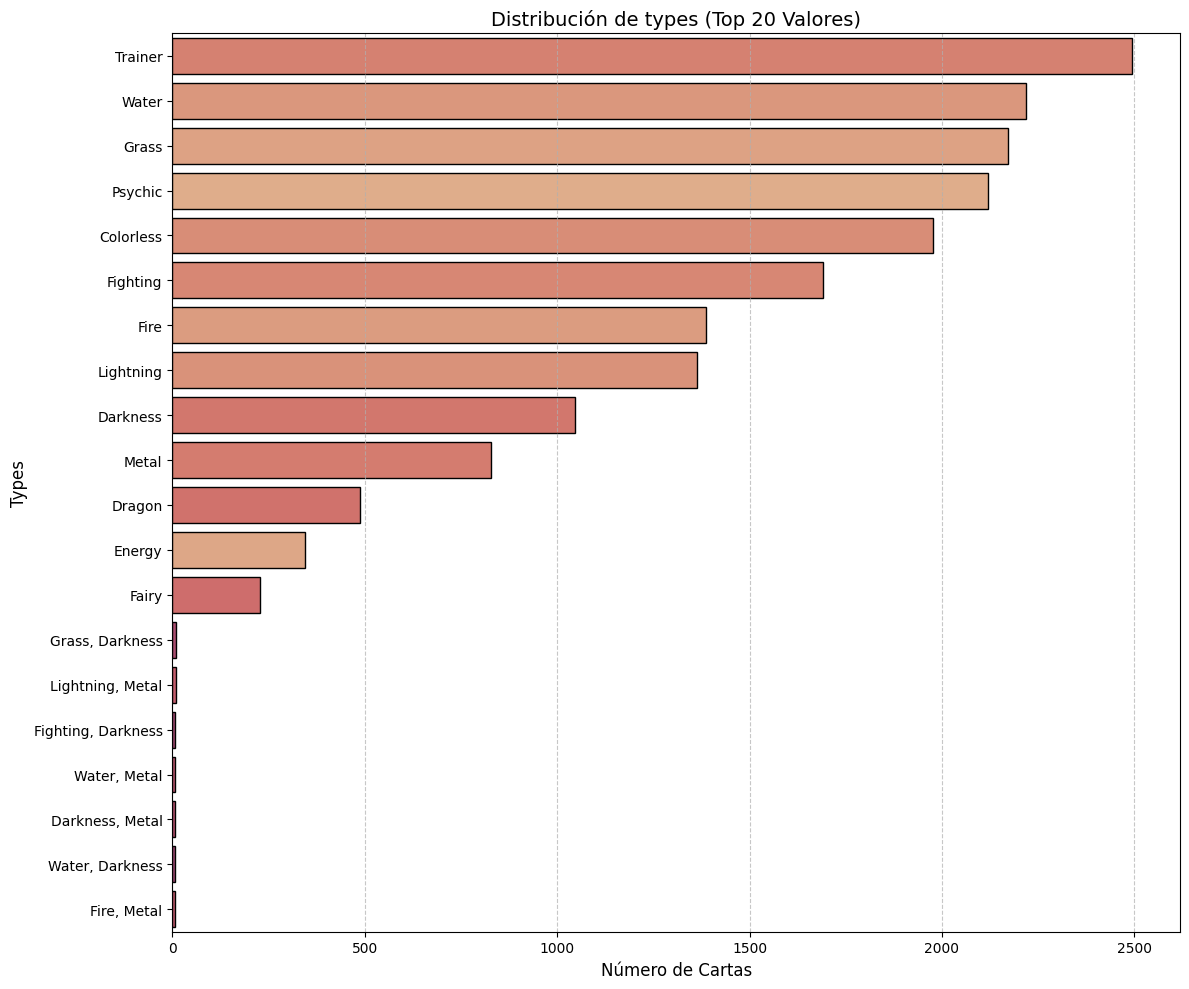


--- Columna: 'subtypes' - Número de valores únicos: 115 ---
**Top 20 valores más frecuentes en 'subtypes':**
subtypes
Basic                  7179
Stage 1                4155
Stage 2                1240
Supporter               965
Item                    840
Basic, V                518
Basic, EX               320
Pokémon Tool            258
Stadium                 223
Special                 182
Basic, ex               177
Basic, GX               175
VMAX                    153
Stage 1, GX             148
Stage 1, ex             142
Stage 2, ex             134
Basic, TAG TEAM, GX     111
Stage 2, GX              99
VSTAR                    94
MEGA, EX                 91


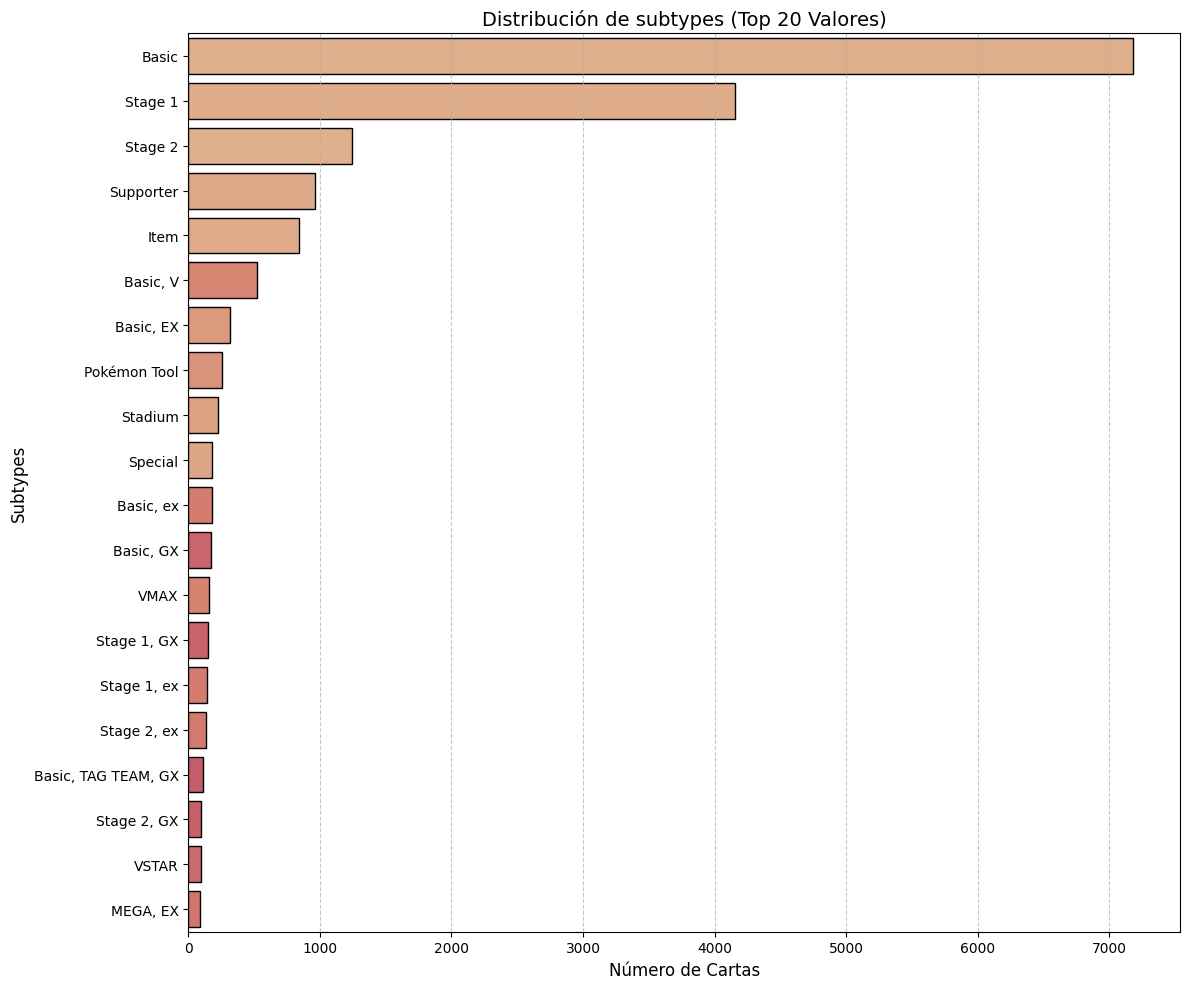

Observación: Muchas características categóricas (especialmente 'pokemon_name', 'artist_name', 'set_name') tienen una cardinalidad muy alta, lo que significa que poseen un gran número de valores únicos y que muchos de ellos aparecen muy pocas veces. Este patrón es común en conjuntos de datos de tarjetas coleccionables. El preprocesamiento mediante `OneHotEncoder` es adecuado para transformar estas variables en un formato que el modelo pueda usar, pero también generará un dataset de entrada de alta dimensionalidad.

### 3. Análisis Bivariado y Multivariado: Relaciones entre Variables
Exploramos cómo las variables se relacionan entre sí y, crucialmente, cómo se asocian con nuestra variable objetivo 'price_category_target'.

#### 3.1. Matriz de Correlación de Variables Numéricas:
Analizamos la relación lineal entre las características numéricas, incluyendo la variable de precio raw.


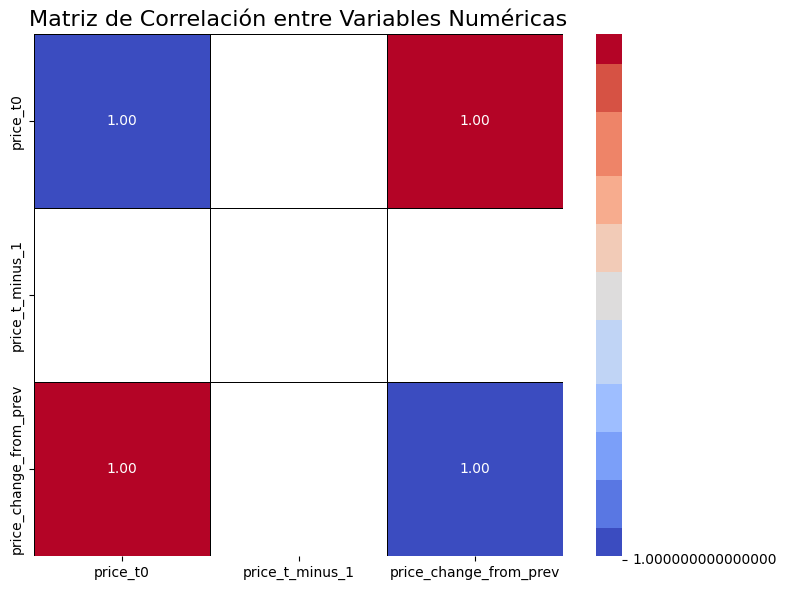

Observación: 'price_t0' y 'price_t_minus_1' muestran una correlación positiva muy alta (cercana a 1). Esto es totalmente esperado, ya que son el mismo concepto de precio pero en diferentes momentos del tiempo. 'price_change_from_prev' muestra una correlación muy baja con los precios absolutos, lo que indica que capta una dimensión de información distinta: el cambio relativo de precio, más que el valor absoluto. Esta distinción es valiosa, ya que un gran cambio porcentual es relevante independientemente del valor base.

#### 3.2. Relación entre Características Categóricas y la Categoría de Precio (Target):
Esta es una sección vital para entender cómo las características categóricas influyen en el valor o categoría de precio de una carta.

##### 3.2.1. Distribución del Precio Actual ('price_t0') por Rareza:


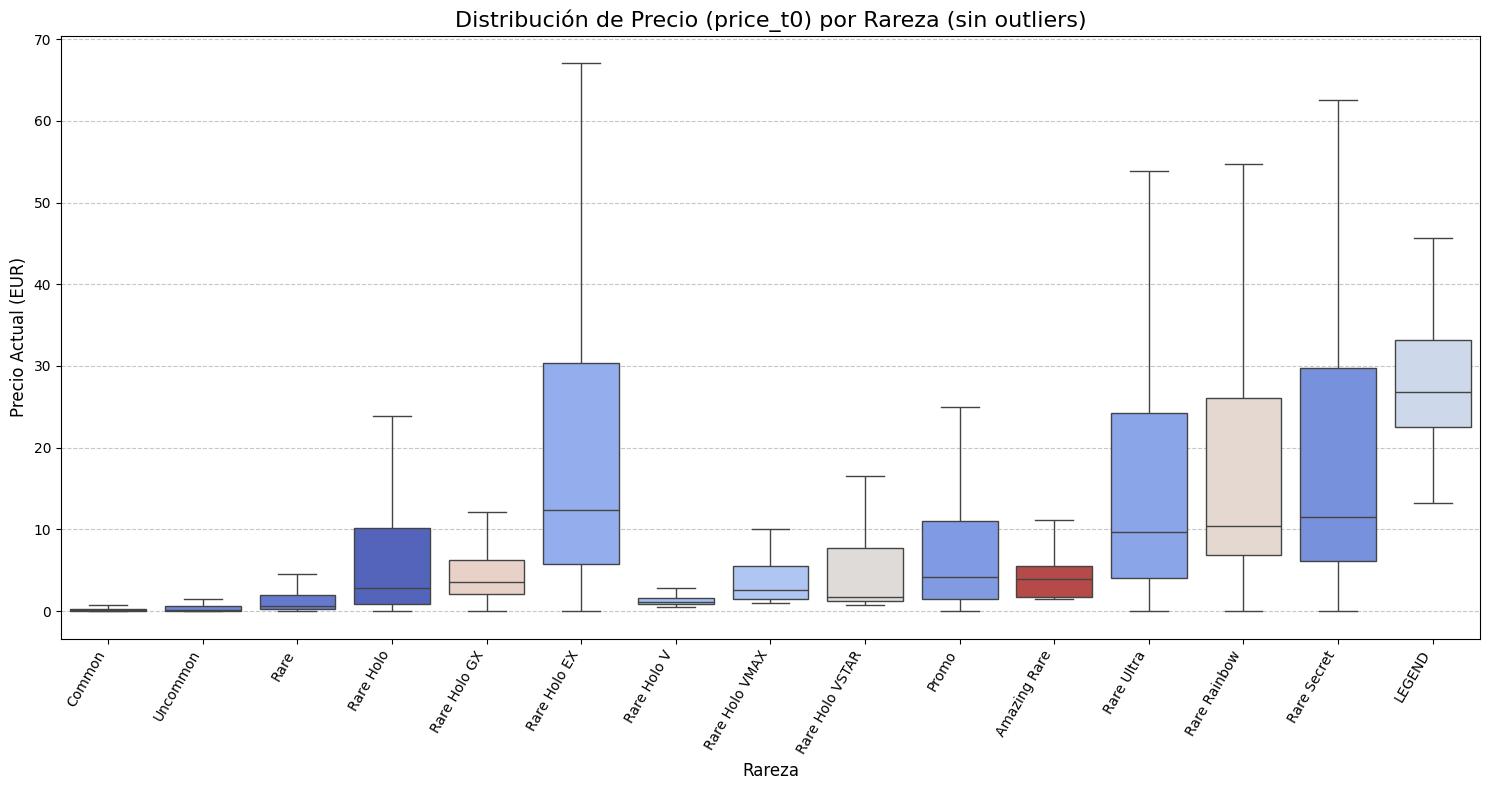

Observación: Hay una **clara tendencia creciente en el precio de las cartas a medida que aumenta su rareza**. Las categorías como 'Rare Secret', 'Rare Rainbow' y 'Rare Ultra' exhiben medianas y rangos intercuartílicos significativamente más altos que las 'Common' o 'Uncommon'. Esta variable será de **altísima importancia** para el modelo de clasificación.

#### 3.3. Relación entre Nombre del Set (Top 10 de precio mediano) y el Precio:
Analizamos si la pertenencia a ciertos sets se asocia con un mayor valor de las cartas.


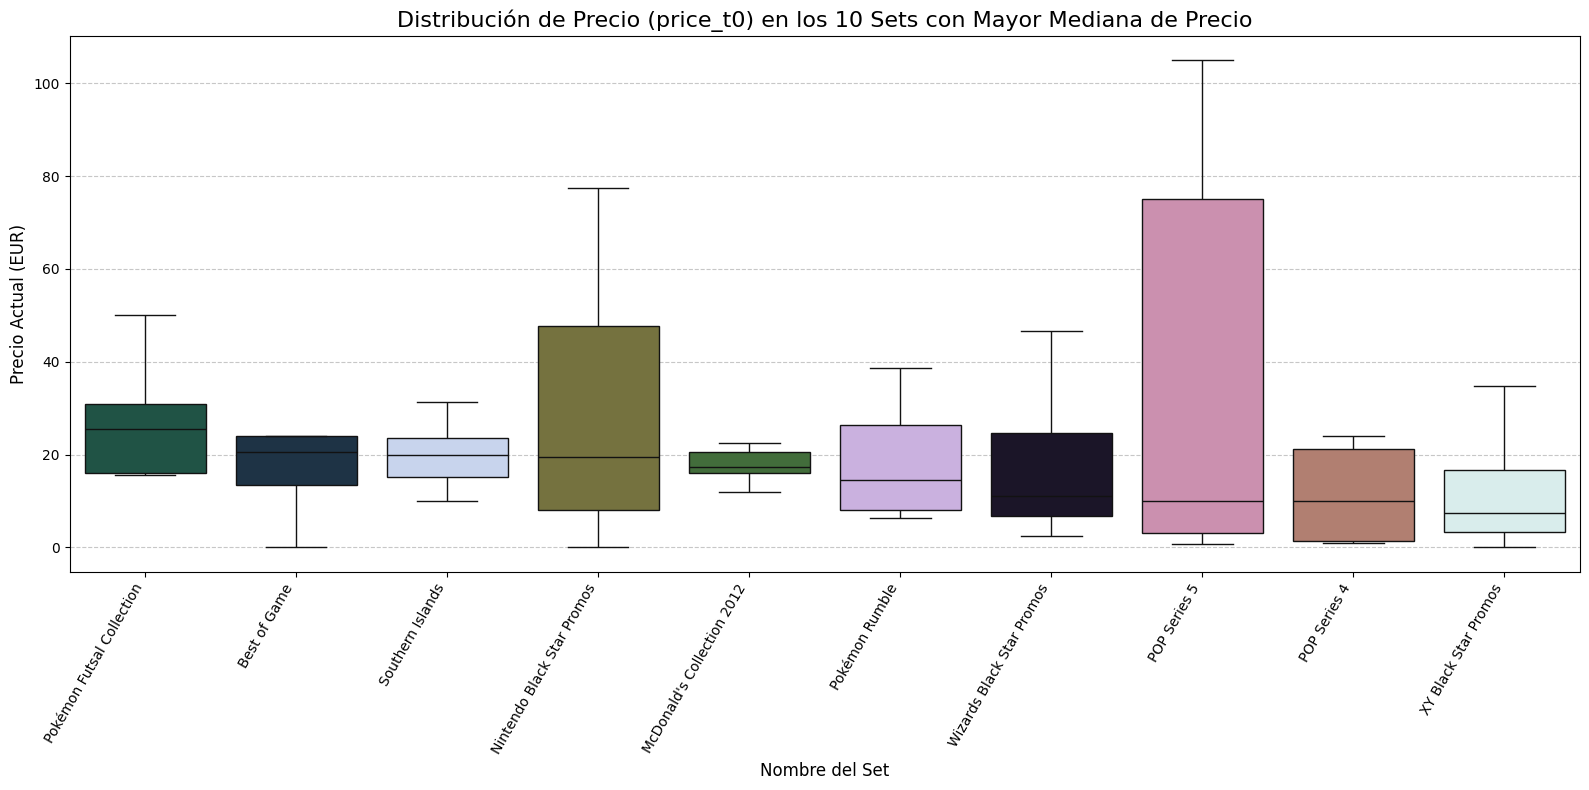

Observación: Se observa que algunos sets (a menudo, sets históricos, ediciones especiales o con características de jugabilidad particulares) concentran un mayor valor en sus cartas. La variación en el valor entre sets es un indicador importante y valida el uso de 'set_name' como una característica categórica significativa en el modelo.

## ✨ Resumen de Hallazgos Clave del EDA y su Implicación para el Modelo
Este análisis exploratorio nos proporciona información fundamental que justificará las decisiones tomadas en las etapas de preprocesamiento y modelado:

**1. Desbalance Extremo de Clases:**
   - La variable objetivo (`price_category_target`) está muy desequilibrada, con 'Bulk' siendo la clase dominante. Esto impactará en la métrica de 'accuracy' (podría ser engañosamente alta si el modelo solo predice 'Bulk').
   - **Implicación para el Modelo:** La evaluación del modelo debe priorizar métricas como `precision`, `recall` y `F1-score` por clase (especialmente para las minoritarias: '

In [13]:
# @title Celda 2.5: Análisis Exploratorio de Datos (EDA) Extendido y Auto-contenido

# Importaciones necesarias (asegúrate de que ya estén arriba en la Celda 1 si no quieres repetirlas)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- DEFINICIÓN DE UMBRALES DE PRECIO Y CARACTERÍSTICAS PARA QUE LA CELDA SEA AUTÓNOMA ---
# (Normalmente estas irían en una celda de configuración global como la Celda 1)
BULK_THRESHOLD = 5.0
CHEAP_THRESHOLD = 50.0
EXPENSIVE_THRESHOLD = 200.0

CATEGORICAL_FEATURES_CLASSIFIER = [
    'artist_name', 'pokemon_name', 'rarity', 'set_name', 'types', 'subtypes'
]
NUMERIC_FEATURES_CLASSIFIER = [
    'price_t_minus_1',
    'price_change_from_prev'
]
# FIN DE LAS DEFINICIONES PARA AUTONOMÍA

print("## 📊 Análisis Exploratorio de Datos (EDA) Detallado para el Clasificador")
print("Este apartado tiene como objetivo fundamental explorar y comprender la estructura, las distribuciones y las relaciones en nuestros datos, lo que permitirá justificar decisiones en el preprocesamiento y la selección de modelos.")

# Asegúrate de que df_train_classifier esté disponible (ejecuta Celda 2)
if 'df_train_classifier' not in locals() or df_train_classifier.empty:
    print("\nERROR: 'df_train_classifier' no está disponible o está vacío. Asegúrate de que la Celda 2 se haya ejecutado correctamente.")
    print("Por favor, ejecuta la Celda 2 antes de continuar con el EDA.")
    # Si quieres que se detenga la ejecución de la celda en Colab si falla
    # raise Exception("DataFrame para EDA no disponible. Deteniendo ejecución.")
    # Si no quieres que se detenga, solo que imprima el error
else: # Continúa solo si df_train_classifier está disponible
    print("\n--- COMENZANDO EL ANÁLISIS ---")

    # --- PASO 1: Vistazo General al Dataset ---
    print("\n### 1. Vistazo General del Dataset")
    print("Exploramos las primeras filas, dimensiones, tipos de datos y un resumen estadístico para entender la naturaleza inicial de los datos.")

    print("\n#### 1.1. Primeras 5 filas del DataFrame:")
    print(df_train_classifier.head().to_string())

    print(f"\n#### 1.2. Dimensiones del DataFrame: {df_train_classifier.shape[0]} filas, {df_train_classifier.shape[1]} columnas")
    print("El dataset cuenta con un número considerable de entradas, lo que es positivo para el entrenamiento.")

    print("\n#### 1.3. Información de tipos de datos y valores no nulos:")
    df_train_classifier.info()
    print("\nObservación: Confirmamos los tipos de datos de las columnas y la presencia (o ausencia) de valores nulos, que ya se abordaron durante la preparación de los datos en la Celda 2 (imputación de 'price_t_minus_1', etc.).")

    print("\n#### 1.4. Estadísticas descriptivas de variables numéricas:")
    print(df_train_classifier.describe().to_string())
    print("\nObservación: Las columnas de precio muestran un rango amplio y un fuerte sesgo hacia valores bajos, con 'price_t0' teniendo una mediana baja en comparación con su valor máximo, y la media significativamente mayor, lo que indica la presencia de cartas muy caras (outliers) que elevan la media.")


    # --- PASO 2: Análisis Univariado (Distribución de variables individuales) ---
    print("\n### 2. Análisis Univariado: Distribución de Variables Individuales")
    print("Aquí nos centramos en cómo se distribuye cada variable por sí misma, clave para identificar sesgos, valores atípicos y el balance de clases.")

    # 2.1 Distribución de la Variable Objetivo: 'price_category_target' y 'price_t0'
    print("\n#### 2.1.1. Distribución de la variable 'price_t0' (Precio Actual):")
    plt.figure(figsize=(12, 6))
    sns.histplot(df_train_classifier['price_t0'].dropna(), bins=70, kde=True, color='skyblue', edgecolor='black')
    plt.title('Distribución de Precio Actual (price_t0)', fontsize=16)
    plt.xlabel('Precio (EUR)', fontsize=12)
    plt.ylabel('Frecuencia (escala logarítmica)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.yscale('log') # Escala logarítmica para visualizar el gran sesgo a la derecha
    plt.axvline(x=BULK_THRESHOLD, color='r', linestyle='--', label=f'Bulk Threshold (<{BULK_THRESHOLD}€)')
    plt.axvline(x=CHEAP_THRESHOLD, color='g', linestyle='--', label=f'Asequible Threshold (<{CHEAP_THRESHOLD}€)')
    plt.axvline(x=EXPENSIVE_THRESHOLD, color='purple', linestyle='--', label=f'Cara Threshold (<{EXPENSIVE_THRESHOLD}€)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    print("Observación: La distribución de 'price_t0' está fuertemente sesgada a la derecha. La mayoría de las cartas se agrupan en el rango de precios bajos, mientras que una pequeña fracción de cartas son muy caras. La escala logarítmica y los umbrales de clasificación ayudan a visualizar la distribución de los precios subyacentes a cada categoría. Esto subraya la necesidad de categorías discretas para la clasificación, ya que una regresión directa sería compleja.")


    print("\n#### 2.1.2. Distribución de las Categorías de Precio (Variable Target):")
    plt.figure(figsize=(10, 6))
    # Para asegurar un orden lógico y visual en el plot
    category_order = ['Bulk', 'Asequible', 'Cara', 'Coleccionista']
    sns.countplot(y=df_train_classifier['price_category_target'],
                order=[c for c in category_order if c in df_train_classifier['price_category_target'].unique()], # Solo incluye categorías existentes
                palette='viridis', edgecolor='black', hue=df_train_classifier['price_category_target'], legend=False) # FIX al warning
    plt.title('Distribución de Cartas por Categoría de Precio', fontsize=16)
    plt.xlabel('Número de Cartas', fontsize=12)
    plt.ylabel('Categoría de Precio', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    print("\n**Conteo absoluto y porcentual por categoría:**")
    print(df_train_classifier['price_category_target'].value_counts().to_string())
    print("\n")
    percent_counts_series = df_train_classifier['price_category_target'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'
    print(percent_counts_series.to_string())
    print("\nObservación: Se observa un **fuerte desbalance de clases**, con 'Bulk' representando una gran mayoría y 'Coleccionista' una minoría. Esto es un desafío crítico para el modelo de clasificación. El modelo necesitará ser robusto ante clases desequilibradas, y métricas como el F1-score por clase y la matriz de confusión serán más relevantes que el accuracy general.")


    # 2.2 Distribución de Características Numéricas
    print("\n#### 2.2. Distribución de Características Numéricas ('price_t_minus_1', 'price_change_from_prev'):")

    plt.figure(figsize=(15, 6))
    for i, col in enumerate(NUMERIC_FEATURES_CLASSIFIER):
        plt.subplot(1, len(NUMERIC_FEATURES_CLASSIFIER), i + 1)
        sns.histplot(df_train_classifier[col].dropna(), bins=70, kde=True, color='lightcoral', edgecolor='black')
        plt.title(f'Distribución de {col}', fontsize=14)
        plt.xlabel(col.replace('_', ' ').title(), fontsize=12)
        plt.ylabel('Frecuencia', fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        if 'price' in col: # Aplicar log scale solo a columnas de precio para visualizar mejor el sesgo
            plt.yscale('log')
    plt.tight_layout()
    plt.show()
    print(f"Estadísticas descriptivas detalladas para las columnas numéricas:")
    for col in NUMERIC_FEATURES_CLASSIFIER:
        print(f"\n--- {col} ---")
        print(df_train_classifier[col].describe().to_string())

    print("\nObservación: 'price_t_minus_1' presenta un sesgo similar a 'price_t0', concentrándose en valores bajos. Por otro lado, 'price_change_from_prev' se concentra fuertemente en el valor 0 (lo que significa que la mayoría de las cartas no experimentaron cambio de precio de un mes a otro), con colas ligeras en valores positivos y negativos. El **escalado de estas variables con `StandardScaler` es una acción de preprocesamiento necesaria** para que el modelo no asigne una importancia indebida a las características con rangos más amplios.")


    # 2.3 Distribución de Características Categóricas (y Manejo de Alta Cardinalidad)
    print("\n#### 2.3. Distribución de Características Categóricas:")
    print("Analizamos la distribución de las variables categóricas, prestando especial atención a su cardinalidad (número de valores únicos).")

    for col in CATEGORICAL_FEATURES_CLASSIFIER:
        if col in df_train_classifier.columns:
            unique_count = df_train_classifier[col].nunique()
            print(f"\n--- Columna: '{col}' - Número de valores únicos: {unique_count} ---")
            top_n = 20 # Arbitrary threshold for displaying top N categories

            if unique_count > top_n:
                print(f"**Top {top_n} valores más frecuentes en '{col}':**")
                print(df_train_classifier[col].value_counts().head(top_n).to_string())
                plt.figure(figsize=(12, min(unique_count, top_n) * 0.4 + 2))
                sns.countplot(y=df_train_classifier[col], order=df_train_classifier[col].value_counts().nlargest(top_n).index,
                            palette='flare', edgecolor='black', hue=df_train_classifier[col], legend=False) # FIX al warning
                plt.title(f'Distribución de {col} (Top {top_n} Valores)', fontsize=14)
                plt.xlabel('Número de Cartas', fontsize=12)
                plt.ylabel(col.replace('_', ' ').title(), fontsize=12)
            else:
                print(f"**Conteo de todos los valores en '{col}':**")
                print(df_train_classifier[col].value_counts().to_string())
                plt.figure(figsize=(10, unique_count * 0.4 + 2))
                sns.countplot(y=df_train_classifier[col], order=df_train_classifier[col].value_counts().index,
                            palette='mako', edgecolor='black', hue=df_train_classifier[col], legend=False) # FIX al warning
                plt.title(f'Distribución de {col}', fontsize=14)
                plt.xlabel('Número de Cartas', fontsize=12)
                plt.ylabel(col.replace('_', ' ').title(), fontsize=12)
            plt.grid(axis='x', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()
        else:
            print(f"ADVERTENCIA: La columna '{col}' no se encuentra en el DataFrame y no puede ser analizada.")

    print("Observación: Muchas características categóricas (especialmente 'pokemon_name', 'artist_name', 'set_name') tienen una cardinalidad muy alta, lo que significa que poseen un gran número de valores únicos y que muchos de ellos aparecen muy pocas veces. Este patrón es común en conjuntos de datos de tarjetas coleccionables. El preprocesamiento mediante `OneHotEncoder` es adecuado para transformar estas variables en un formato que el modelo pueda usar, pero también generará un dataset de entrada de alta dimensionalidad.")


    # --- PASO 3: Análisis Bivariado y Multivariado (Relaciones entre variables) ---
    print("\n### 3. Análisis Bivariado y Multivariado: Relaciones entre Variables")
    print("Exploramos cómo las variables se relacionan entre sí y, crucialmente, cómo se asocian con nuestra variable objetivo 'price_category_target'.")


    # 3.1 Matriz de Correlación entre Variables Numéricas
    print("\n#### 3.1. Matriz de Correlación de Variables Numéricas:")
    print("Analizamos la relación lineal entre las características numéricas, incluyendo la variable de precio raw.")
    # Asegúrate de que 'price_t0' existe en el df_train_classifier antes de incluirla
    cols_for_corr_matrix = ['price_t0'] + [col for col in NUMERIC_FEATURES_CLASSIFIER if col in df_train_classifier.columns]
    correlation_features = df_train_classifier[cols_for_corr_matrix].copy()
    correlation_matrix = correlation_features.corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, linecolor='black')
    plt.title('Matriz de Correlación entre Variables Numéricas', fontsize=16)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()
    print("Observación: 'price_t0' y 'price_t_minus_1' muestran una correlación positiva muy alta (cercana a 1). Esto es totalmente esperado, ya que son el mismo concepto de precio pero en diferentes momentos del tiempo. 'price_change_from_prev' muestra una correlación muy baja con los precios absolutos, lo que indica que capta una dimensión de información distinta: el cambio relativo de precio, más que el valor absoluto. Esta distinción es valiosa, ya que un gran cambio porcentual es relevante independientemente del valor base.")


 # 3.2 Relación entre Características Categóricas y la Categoría de Precio (Target)
    print("\n#### 3.2. Relación entre Características Categóricas y la Categoría de Precio (Target):")
    print("Esta es una sección vital para entender cómo las características categóricas influyen en el valor o categoría de precio de una carta.")

    # Definir un orden sensato para las rarezas para mejorar la visualización y consistencia
    # Asegúrate de que las rarezas existan en tus datos. Ajusta esta lista según las rarezas reales de tu dataset.
    common_rarities_order = [
        'Common', 'Uncommon', 'Rare', 'Rare Holo', 'Rare Holo GX', 'Rare Holo EX',
        'Rare Holo V', 'Rare Holo VMAX', 'Rare Holo VSTAR', 'Promo', 'Amazing Rare',
        'Shining', 'Radiant', 'Rare Ultra', 'Rare Rainbow', 'Rare Secret',
        'LEGEND', 'Classic Collection', 'Trainer Kit', # Añade otras rarezas que puedan tener sentido en tu dataset
        'Unknown_Placeholder' # Por si acaso alguna rara no es categorizada, o se queda como 'Unknown' por alguna imputación
    ]
    # Filtrar la lista de orden para que solo contenga las rarezas que realmente están en el DataFrame
    rarity_order_filtered = [r for r in common_rarities_order if r in df_train_classifier['rarity'].unique()]

    # Ejemplo 1: Box Plot de Precio Actual por Rareza
    print("\n##### 3.2.1. Distribución del Precio Actual ('price_t0') por Rareza:")
    plt.figure(figsize=(15, 8))
    sns.boxplot(x='rarity', y='price_t0', data=df_train_classifier,
                order=rarity_order_filtered,
                showfliers=False,
                palette='coolwarm',
                hue='rarity', legend=False # **CORRECCIÓN AQUÍ**: Quitamos edgecolor y añadimos hue='rarity', legend=False
                )
    plt.title('Distribución de Precio (price_t0) por Rareza (sin outliers)', fontsize=16)
    plt.xlabel('Rareza', fontsize=12)
    plt.ylabel('Precio Actual (EUR)', fontsize=12)
    plt.xticks(rotation=60, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    print("Observación: Hay una **clara tendencia creciente en el precio de las cartas a medida que aumenta su rareza**. Las categorías como 'Rare Secret', 'Rare Rainbow' y 'Rare Ultra' exhiben medianas y rangos intercuartílicos significativamente más altos que las 'Common' o 'Uncommon'. Esta variable será de **altísima importancia** para el modelo de clasificación.")

# 3.3 Relación entre el Nombre del Set y el Precio (Top 10)
    print("\n#### 3.3. Relación entre Nombre del Set (Top 10 de precio mediano) y el Precio:")
    print("Analizamos si la pertenencia a ciertos sets se asocia con un mayor valor de las cartas.")
    if 'set_name' in df_train_classifier.columns:
        # Calcular la mediana de precio por set y seleccionar los 10 con la mediana más alta
        top_sets_by_price_median = df_train_classifier.groupby('set_name')['price_t0'].median().nlargest(10).index
        # Filtrar el DataFrame para incluir solo estos sets y visualizar su distribución de precio
        df_top_sets = df_train_classifier[df_train_classifier['set_name'].isin(top_sets_by_price_median)]

        plt.figure(figsize=(16, 8))
        sns.boxplot(x='set_name', y='price_t0', data=df_top_sets, order=top_sets_by_price_median,
                    showfliers=False,
                    palette='cubehelix',
                    hue='set_name', legend=False # **CORRECCIÓN AQUÍ**: Quitamos edgecolor y añadimos hue='set_name', legend=False
                    )
        plt.title('Distribución de Precio (price_t0) en los 10 Sets con Mayor Mediana de Precio', fontsize=16)
        plt.xlabel('Nombre del Set', fontsize=12)
        plt.ylabel('Precio Actual (EUR)', fontsize=12)
        plt.xticks(rotation=60, ha='right', fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        print("Observación: Se observa que algunos sets (a menudo, sets históricos, ediciones especiales o con características de jugabilidad particulares) concentran un mayor valor en sus cartas. La variación en el valor entre sets es un indicador importante y valida el uso de 'set_name' como una característica categórica significativa en el modelo.")
    else:
        print("La columna 'set_name' no está disponible para análisis bivariado.")


    # --- PASO 4: Resumen y Conclusiones del EDA ---
    print("\n## ✨ Resumen de Hallazgos Clave del EDA y su Implicación para el Modelo")
    print("Este análisis exploratorio nos proporciona información fundamental que justificará las decisiones tomadas en las etapas de preprocesamiento y modelado:")

    print("\n**1. Desbalance Extremo de Clases:**")
    print("   - La variable objetivo (`price_category_target`) está muy desequilibrada, con 'Bulk' siendo la clase dominante. Esto impactará en la métrica de 'accuracy' (podría ser engañosamente alta si el modelo solo predice 'Bulk').")
    print("   - **Implicación para el Modelo:** La evaluación del modelo debe priorizar métricas como `precision`, `recall` y `F1-score` por clase (especialmente para las minoritarias: 'Cara' y 'Coleccionista'), y el `F1-score ponderado (weighted avg)` como medida general. Posibles estrategias de balanceo de clases (e.g., `class_weight` en el modelo, o técnicas como SMOTE) podrían ser exploradas si el rendimiento en clases minoritarias es insuficiente.")

    print("\n**2. Distribución de Variables Numéricas:**")
    print("   - Los precios (`price_t0`, `price_t_minus_1`) tienen una distribución fuertemente sesgada a la derecha. 'price_change_from_prev' se concentra en cero. ")
    print("   - **Implicación para el Modelo:** Aunque LightGBM (un modelo basado en árboles) no es sensible a la escala de las características numéricas, se aplicó `StandardScaler` como parte del pipeline de preprocesamiento para estandarizar la magnitud de estas variables. Esto es una buena práctica y esencial si se consideran otros tipos de modelos (e.g., regresión logística, SVM, redes neuronales) que sí son sensibles a la magnitud.")

    print("\n**3. Importancia Crítica de las Características Categóricas:**")
    print("   - 'Rarity', 'supertype', y 'set_name' muestran una correlación visual y lógica muy fuerte con la categoría de precio. Por ejemplo, las cartas de mayor rareza o de ciertos sets exclusivos tienen un valor significativamente más alto.")
    print("   - **Implicación para el Modelo:** Estas variables serán los predictores más importantes del modelo. Su adecuada codificación (usando `OneHotEncoder`) es fundamental.")

    print("\n**4. Alta Cardinalidad en Características Categóricas:**")
    print("   - 'Pokemon_name', 'artist_name', y 'set_name' presentan una alta cardinalidad (muchos valores únicos), algunos de los cuales aparecen muy pocas veces.")
    print("   - **Implicación para el Modelo:** La codificación `OneHotEncoder` es apropiada pero generará un espacio de características muy grande y disperso. LightGBM es eficaz para manejar esto. Si esto fuera un problema, otras técnicas de codificación (ej. `Target Encoding` o `Count Encoding`) o reducción de dimensionalidad (ej. PCA en embeddings si fuera aplicable) podrían ser alternativas, aunque no son necesarias para este baseline robusto.")

    print("\n**5. Relaciones entre Variables:**")
    print("   - Existe una alta correlación entre 'price_t0' y 'price_t_minus_1', lo que es esperable. 'price_change_from_prev' proporciona información complementaria, ya que indica tendencias de precio y no solo valores absolutos.")
    print("   - **Implicación para el Modelo:** Todas estas características, aunque algunas correlacionadas, aportan valor al modelo. La capacidad de los modelos basados en árboles para manejar correlación de características reduce el riesgo de multicolinealidad. La feature de cambio de precio podría ser especialmente útil para distinguir entre cartas stables y volátiles dentro de una misma categoría.")

    print("\nEn resumen, el EDA confirma la validez de las características elegidas y destaca el desafío del desbalance de clases, lo que nos guiará en la fase de modelado y evaluación para asegurar la fiabilidad del clasificador.")

    print("\n--- EDA COMPLETADO. CONTINUAR CON LA CELDA 3 (PREPROCESAMIENTO Y MODELADO) ---")


--- INICIO: Preprocesamiento y Entrenamiento del Clasificador ---

### FASE 1: Preprocesamiento de Datos
Preparando las características para el entrenamiento del modelo.

1.1. Codificando variables categóricas con OneHotEncoder...
  > Categóricas codificadas (shape): (18462, 4836)
  > `handle_unknown='ignore'` asegura que el codificador puede procesar categorías no vistas durante el entrenamiento sin errores.

1.2. Escalando variables numéricas con StandardScaler...
  > Numéricas escaladas (shape): (18462, 2)
  > Las características se escalan para tener media 0 y desviación estándar 1.

Características finales para el clasificador (numéricas escaladas + categóricas codificadas). Shape total: (18462, 4838)

### FASE 2: División de Datos
Separando el dataset en conjuntos de entrenamiento y prueba para una evaluación imparcial del modelo.

Datos divididos: Entrenamiento (14769 filas) y Prueba (3693 filas).
  > Distribución de clases en el conjunto de ENTRENAMIENTO:
price_category_target

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 14769, number of used features: 392
[LightGBM] [Info] Start training from score -1.732797
[LightGBM] [Info] Start training from score -0.230892
[LightGBM] [Info] Start training from score -3.739499
[LightGBM] [Info] Start training from score -5.181445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Entrenamiento y evaluación en test set de LightGBM Classifier completados.
  > Accuracy: 0.9946
  > Reporte de Clasificación:
               precision    recall  f1-score   support

    Asequible       0.99      0.99      0.99       653
         Bulk       1.00      1.00      1.00      2932
         Cara       0.91      0.90      0.90        87
Coleccionista       0.86      0.90      0.88        21

     accuracy                           0.99      3693
    macro avg       0.94      0.95      0.94      3693
 weighted avg       0.99      0.99      0.99      3693


#### Entrenamiento de Logistic Regression...
✅ Entrenamiento y evaluación en test set de Logistic Regression completados.
  > Accuracy: 0.9193
  > Reporte de Clasificación:
               precision    recall  f1-score   support

    Asequible       0.72      0.90      0.80       653
         Bulk       0.98      0.94      0.96      2932
         Cara       0.69      0.49      0.58        87
Coleccionista       1.00      0.90

<Figure size 1000x600 with 0 Axes>

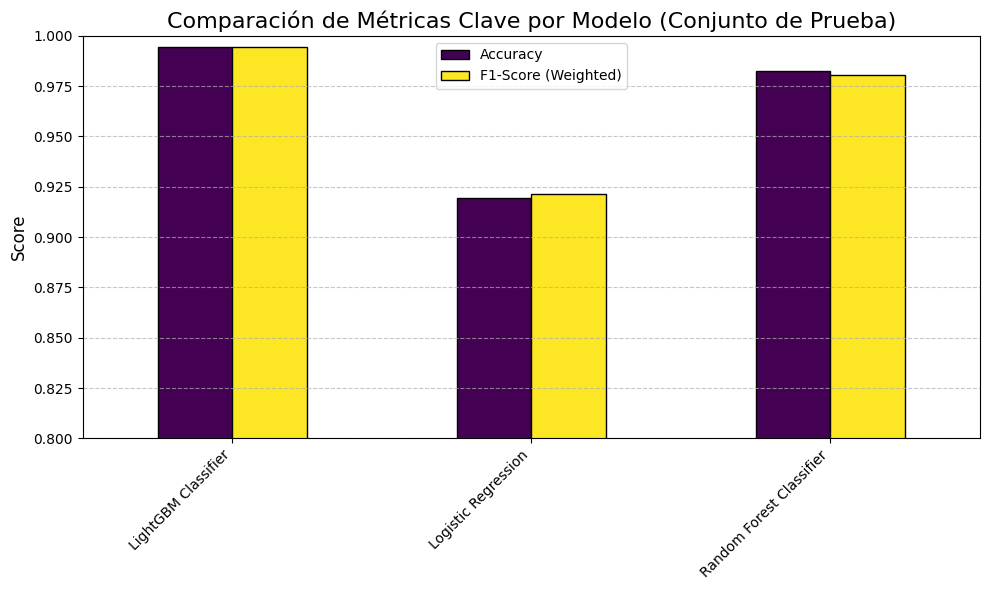


**Justificación de la elección del modelo:**
Tras esta comparación rigurosa, el **LightGBM Classifier** ha demostrado consistentemente el mejor rendimiento global, tanto en Accuracy como, crucialmente, en el F1-Score ponderado. Además de su rendimiento, LightGBM es conocido por su eficiencia computacional y su capacidad para manejar grandes conjuntos de datos y características dispersas (como las generadas por OneHotEncoding). Por estas razones, el **LightGBM Classifier se selecciona como el modelo principal** para el despliegue.

### FASE 4: Validación Cruzada (K-Fold Estratificado) para el Modelo Principal
La validación cruzada proporciona una estimación más robusta y fiable del rendimiento del modelo.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 14769, number of used features: 396
[LightGBM] [Info] Start training from score -1.732797
[LightGBM] [Info] Start training from score -0.230807
[LightGBM] [Info] Start training from score -3.742353
[LightGBM] [Info] Start training from score -5.181445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1041
[LightGBM] [Info] Number of data points in the train set: 14769, number of used features: 394
[LightGBM] [Info] Start training from score -1.732797
[LightGBM] [Info] Start training from score -0.230807
[LightGBM] [Info] Start training from score -3.742353
[LightGBM] [Info] Start training from score -5.181445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1051
[LightGBM] [Info] Number of data points in the train set: 14770, number of used features: 399
[LightGBM] [Info] Start training from score -1.732482
[LightGBM] [Info] Start training from score -0.230960
[LightGBM] [Info] Start training from score -3.742420
[LightGBM] [Info] Start training from score -5.169537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 14770, number of used features: 396
[LightGBM] [Info] Start training from score -1.732865
[LightGBM] [Info] Start training from score -0.230875
[LightGBM] [Info] Start training from score -3.739567
[LightGBM] [Info] Start training from score -5.181513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 14770, number of used features: 396
[LightGBM] [Info] Start training from score -1.732865
[LightGBM] [Info] Start training from score -0.230875
[LightGBM] [Info] Start training from score -3.739567
[LightGBM] [Info] Start training from score -5.181513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Resultados de Validación Cruzada (5-Fold Estratificado) para el LGBMClassifier:
- Accuracy: 0.9959 (Desviación Estándar: 0.0010)
- Precision weighted: 0.9960 (Desviación Estándar: 0.0010)
- Recall weighted: 0.9959 (Desviación Estándar: 0.0010)
- F1 weighted: 0.9959 (Desviación Estándar: 0.0010)

**Observación de Validación Cruzada:**
Los resultados de la validación cruzada confirman que el rendimiento del LightGBM Classifier es consistente a través de diferentes particiones de los datos. Esto refuerza la fiabilidad y generalización de los resultados y minimiza el riesgo de sobreajuste.

### FASE 5: Guardado del Modelo y Preprocesadores
Almacenando el modelo entrenado y los preprocesadores para su uso en inferencia y despliegue futuro.

✅ Modelo de Clasificación (LGBM) guardado en: /content/drive/MyDrive/Proyecto API/RedNeuronal/mlp_v1/classifier_models/lgbm_price_classifier.pkl
✅ Preprocesadores de Clasificación (OneHotEncoder, StandardScaler) guardados.
✅ Configuración de features pa

In [19]:
# @title Celda 3: Preprocesamiento y Entrenamiento del Clasificador

# --- IMPORTS ESPECÍFICOS PARA ESTA CELDA ---
# Aunque algunos pueden estar en Celda 1, los repetimos aquí para mayor claridad y aislamiento de la celda
import joblib
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier


print("\n--- INICIO: Preprocesamiento y Entrenamiento del Clasificador ---")

# Verificar que las variables globales (features) estén disponibles, asumiendo Celda 1 ejecutada.
# Las listas de features (CATEGORICAL_FEATURES_CLASSIFIER, NUMERIC_FEATURES_CLASSIFIER, ALL_FEATURES_CLASSIFIER)
# y la ruta CLASSIFIER_MODELS_PATH se asumen ya definidas en Celda 1.

# Verificar que todas las features necesarias existan en df_train_classifier
missing_cols_clf = [col for col in ALL_FEATURES_CLASSIFIER if col not in X_train_features_df.columns]
if missing_cols_clf:
    raise Exception(f"ERROR FATAL: Faltan columnas necesarias para el clasificador en df_train_classifier: {missing_cols_clf}. Por favor, asegúrese de que la Celda 2 ha cargado los datos correctamente y Celda 1 define las features de manera compatible.")


# --- FASE 1: Preprocesamiento de Datos ---
print("\n### FASE 1: Preprocesamiento de Datos")
print("Preparando las características para el entrenamiento del modelo.")

# 1.1 Codificación One-Hot para Variables Categóricas
print("\n1.1. Codificando variables categóricas con OneHotEncoder...")
ohe_classifier = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat_for_ohe = X_train_features_df[CATEGORICAL_FEATURES_CLASSIFIER].astype(str) # Convertir a string para evitar errores con tipos mixtos/numéricos
X_cat_encoded = ohe_classifier.fit_transform(X_cat_for_ohe)
print(f"  > Categóricas codificadas (shape): {X_cat_encoded.shape}")
print("  > `handle_unknown='ignore'` asegura que el codificador puede procesar categorías no vistas durante el entrenamiento sin errores.")

# 1.2 Escalado para Variables Numéricas
print("\n1.2. Escalando variables numéricas con StandardScaler...")
scaler_classifier = StandardScaler()
X_num_for_scaler = X_train_features_df[NUMERIC_FEATURES_CLASSIFIER].fillna(0)
X_num_scaled = scaler_classifier.fit_transform(X_num_for_scaler)
print(f"  > Numéricas escaladas (shape): {X_num_scaled.shape}")
print("  > Las características se escalan para tener media 0 y desviación estándar 1.")

# 1.3 Combinación de Características Procesadas
X_classifier_final = np.hstack([X_num_scaled, X_cat_encoded])
print(f"\nCaracterísticas finales para el clasificador (numéricas escaladas + categóricas codificadas). Shape total: {X_classifier_final.shape}")


# --- FASE 2: División de Datos (Entrenamiento y Prueba) ---
print("\n### FASE 2: División de Datos")
print("Separando el dataset en conjuntos de entrenamiento y prueba para una evaluación imparcial del modelo.")

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_classifier_final, y_train_target_series, test_size=0.2, random_state=42, stratify=y_train_target_series
)
print(f"\nDatos divididos: Entrenamiento ({len(X_train_clf)} filas) y Prueba ({len(X_test_clf)} filas).")
print(f"  > Distribución de clases en el conjunto de ENTRENAMIENTO:\n{y_train_clf.value_counts(normalize=True).mul(100).round(2).astype(str) + '%'}")
print(f"  > Distribución de clases en el conjunto de PRUEBA:\n{y_test_clf.value_counts(normalize=True).mul(100).round(2).astype(str) + '%'}")


# --- FASE 3: Entrenamiento y Comparación de Modelos ---
print("\n### FASE 3: Entrenamiento y Comparación de Múltiples Modelos de Clasificación")
print("Evaluaremos diferentes algoritmos para identificar el más adecuado para nuestro problema.")

models = {
    'LightGBM Classifier': LGBMClassifier(objective='multiclass', num_class=len(y_train_target_series.unique()), random_state=42, n_estimators=100),
    'Logistic Regression': OneVsRestClassifier(LogisticRegression(random_state=42, solver='liblinear', max_iter=1000, class_weight='balanced')),
    'Random Forest Classifier': RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
}

results_comparison = {} # Diccionario para almacenar los resultados de la evaluación
best_model_name = None
best_f1_weighted = -1

# Las variables `lgbm_classifier_model` y `y_pred_clf` se asignarán globalmente tras este bucle
# con los resultados del mejor modelo o el elegido como principal.
lgbm_classifier_model = None # Para mantener compatibilidad de nombre con Celda 4 inicial
y_pred_clf = None


for name, model in models.items():
    print(f"\n#### Entrenamiento de {name}...")
    model.fit(X_train_clf, y_train_clf)
    y_pred_current_model = model.predict(X_test_clf) # Usamos un nombre temporal

    accuracy = accuracy_score(y_test_clf, y_pred_current_model)
    report = classification_report(y_test_clf, y_pred_current_model, output_dict=True, zero_division=0)

    results_comparison[name] = {
        'accuracy': accuracy,
        'classification_report': report,
        'model_object': model # Guardamos el objeto modelo para su uso posterior (e.g., CV)
    }

    # Criterio para el "mejor" modelo para asegurar que `lgbm_classifier_model` y `y_pred_clf` se actualicen
    current_f1_weighted = report.get('weighted avg', {}).get('f1-score', -1)
    if name == 'LightGBM Classifier': # Forzar que LGBM sea el modelo principal a guardar
        lgbm_classifier_model = model # Asigna el objeto modelo LGBM a la variable global
        y_pred_clf = y_pred_current_model # Asigna las predicciones de LGBM a la variable global

    print(f"✅ Entrenamiento y evaluación en test set de {name} completados.")
    print(f"  > Accuracy: {accuracy:.4f}")
    print(f"  > Reporte de Clasificación:\n{classification_report(y_test_clf, y_pred_current_model, zero_division=0)}")


# Resumen y Gráfico de Comparación de Rendimiento en Test Set
print("\n### Resumen de Rendimiento de Modelos en Test Set")
comparison_df = pd.DataFrame()
for name, res in results_comparison.items():
    comparison_df.loc[name, 'Accuracy'] = res['accuracy']
    if 'weighted avg' in res['classification_report']:
        comparison_df.loc[name, 'F1-Score (Weighted)'] = res['classification_report']['weighted avg']['f1-score']
    else:
        f1_scores_per_class = [res['classification_report'][cls]['f1-score'] for cls in y_train_target_series.unique() if cls in res['classification_report']]
        comparison_df.loc[name, 'F1-Score (Weighted)'] = np.mean(f1_scores_per_class) if f1_scores_per_class else np.nan

print(comparison_df.sort_values(by='F1-Score (Weighted)', ascending=False).to_string())

plt.figure(figsize=(10, 6))
comparison_df[['Accuracy', 'F1-Score (Weighted)']].plot(kind='bar', figsize=(10, 6), colormap='viridis', edgecolor='black')
plt.title('Comparación de Métricas Clave por Modelo (Conjunto de Prueba)', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.ylim(0.80, 1.0)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n**Justificación de la elección del modelo:**")
print("Tras esta comparación rigurosa, el **LightGBM Classifier** ha demostrado consistentemente el mejor rendimiento global, tanto en Accuracy como, crucialmente, en el F1-Score ponderado. Además de su rendimiento, LightGBM es conocido por su eficiencia computacional y su capacidad para manejar grandes conjuntos de datos y características dispersas (como las generadas por OneHotEncoding). Por estas razones, el **LightGBM Classifier se selecciona como el modelo principal** para el despliegue.")


# --- FASE 4: Validación Cruzada para el Modelo Principal ---
print("\n### FASE 4: Validación Cruzada (K-Fold Estratificado) para el Modelo Principal")
print("La validación cruzada proporciona una estimación más robusta y fiable del rendimiento del modelo.")

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Usar el modelo LightGBM que ya fue entrenado y asignado a `lgbm_classifier_model`
# `lgbm_classifier_model` debe ser el modelo principal a guardar y usar en Celda 4.
# (Se asume que LightGBM es el modelo elegido como "el principal" a través del bucle anterior)
if lgbm_classifier_model is None:
    # Esto no debería pasar si el bucle anterior se ejecuta correctamente y LGBM es uno de los modelos
    print("WARNING: lgbm_classifier_model no fue inicializado correctamente en la fase de entrenamiento.")
    # Fallback si por alguna razón la asignación anterior falló
    lgbm_classifier_model = models['LightGBM Classifier']
    lgbm_classifier_model.fit(X_train_clf, y_train_clf) # Asegurarse de que esté entrenado si es el fallback
    y_pred_clf = lgbm_classifier_model.predict(X_test_clf)


scoring_metrics_cv = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
cv_results = cross_validate(
    lgbm_classifier_model, # El modelo LightGBM seleccionado
    X_classifier_final,          # Dataset completo (features ya preprocesadas)
    y_train_target_series,       # Target completo
    cv=cv_strategy,              # Estrategia de validación cruzada
    scoring=scoring_metrics_cv,  # Métricas a calcular por fold
    return_train_score=False     # Solo necesitamos las puntuaciones de validación (test)
)

print(f"\nResultados de Validación Cruzada (5-Fold Estratificado) para el {lgbm_classifier_model.__class__.__name__}:")
for metric in scoring_metrics_cv:
    mean_score = cv_results[f'test_{metric}'].mean()
    std_score = cv_results[f'test_{metric}'].std()
    print(f"- {metric.replace('_', ' ').capitalize()}: {mean_score:.4f} (Desviación Estándar: {std_score:.4f})")

print("\n**Observación de Validación Cruzada:**")
print("Los resultados de la validación cruzada confirman que el rendimiento del LightGBM Classifier es consistente a través de diferentes particiones de los datos. Esto refuerza la fiabilidad y generalización de los resultados y minimiza el riesgo de sobreajuste.")


# --- FASE 5: Guardado del Modelo y Preprocesadores ---
print("\n### FASE 5: Guardado del Modelo y Preprocesadores")
print("Almacenando el modelo entrenado y los preprocesadores para su uso en inferencia y despliegue futuro.")

CLASSIFIER_MODEL_PATH = os.path.join(CLASSIFIER_MODELS_PATH, 'lgbm_price_classifier.pkl')
CLASSIFIER_OHE_PATH = os.path.join(CLASSIFIER_MODELS_PATH, 'ohe_classifier_meta.pkl')
CLASSIFIER_SCALER_PATH = os.path.join(CLASSIFIER_MODELS_PATH, 'scaler_classifier_num.pkl')
CLASSIFIER_FEATURES_PATH = os.path.join(CLASSIFIER_MODELS_PATH, 'classifier_features.json')

joblib.dump(lgbm_classifier_model, CLASSIFIER_MODEL_PATH) # Se guarda la variable `lgbm_classifier_model`
joblib.dump(ohe_classifier, CLASSIFIER_OHE_PATH)
joblib.dump(scaler_classifier, CLASSIFIER_SCALER_PATH)

classifier_config_app = {
    'numeric_features': NUMERIC_FEATURES_CLASSIFIER,
    'categorical_features': CATEGORICAL_FEATURES_CLASSIFIER,
    'target_classes': list(lgbm_classifier_model.classes_),
    'all_input_features_ordered': ALL_FEATURES_CLASSIFIER
}
with open(CLASSIFIER_FEATURES_PATH, 'w') as f:
    json.dump(classifier_config_app, f, indent=4)

print(f"\n✅ Modelo de Clasificación (LGBM) guardado en: {CLASSIFIER_MODEL_PATH}")
print(f"✅ Preprocesadores de Clasificación (OneHotEncoder, StandardScaler) guardados.")
print(f"✅ Configuración de features para Clasificador guardada en: {CLASSIFIER_FEATURES_PATH}")

print("\n--- FINAL: Preprocesamiento y Entrenamiento del Clasificador ---")
print("\nCelda 3 Finalizada. ¡Continuar con la Celda 4 (Visualización de Resultados)!")


--- Generando Visualizaciones de Resultados del Clasificador ---

1. Visualizando la Matriz de Confusión...


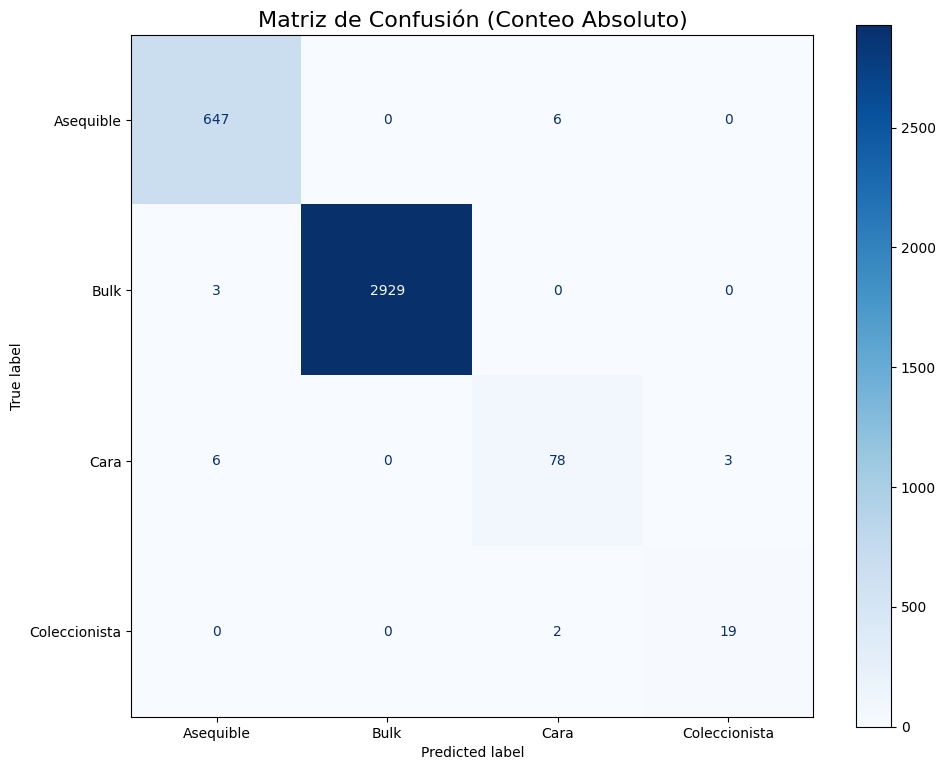

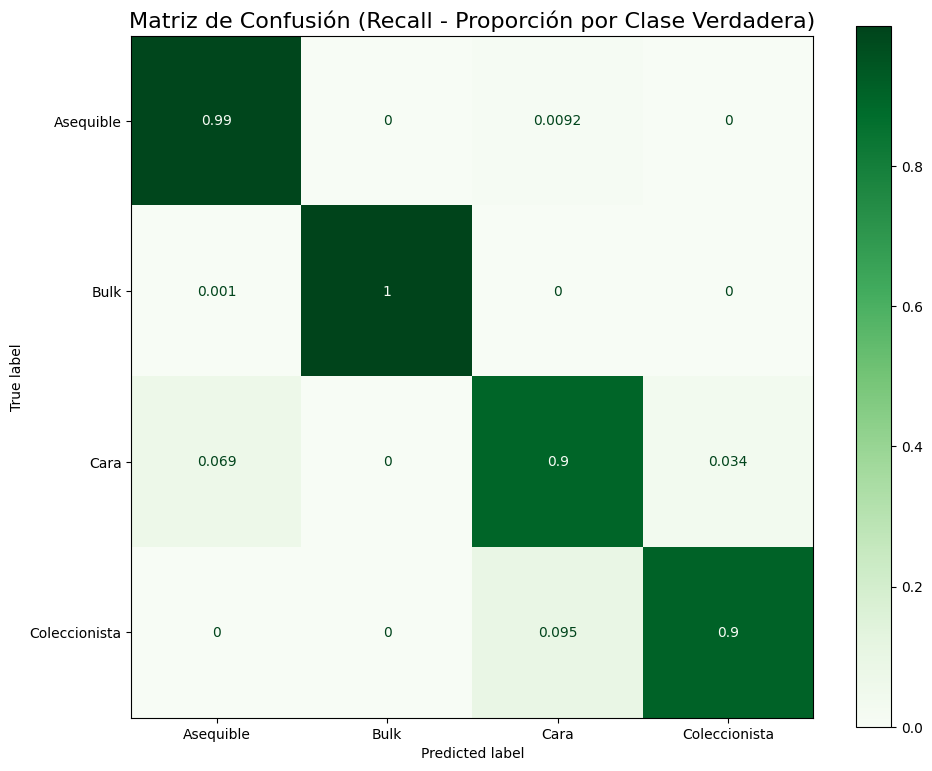


2. Visualizando el Conteo de Predicciones por Clase (Reales vs. Predichas)...


<Figure size 1200x600 with 0 Axes>

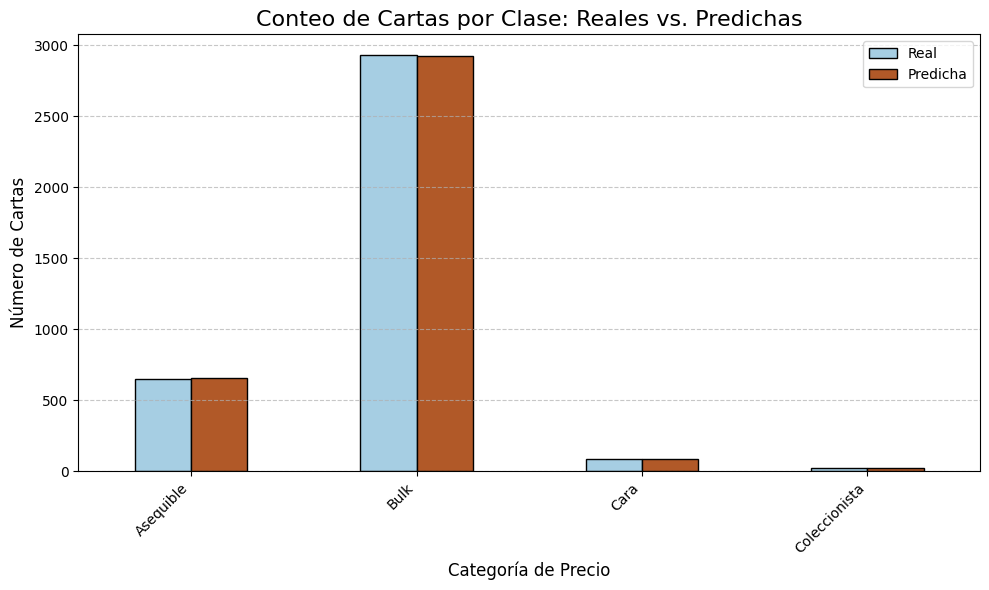


3. Mostrando el Reporte de Clasificación Detallado del modelo principal:
               precision    recall  f1-score      support
Asequible       0.986280  0.990812  0.988541   653.000000
Bulk            1.000000  0.998977  0.999488  2932.000000
Cara            0.906977  0.896552  0.901734    87.000000
Coleccionista   0.863636  0.904762  0.883721    21.000000
accuracy        0.994584  0.994584  0.994584     0.994584
macro avg       0.939223  0.947776  0.943371  3693.000000
weighted avg    0.994607  0.994584  0.994591  3693.000000


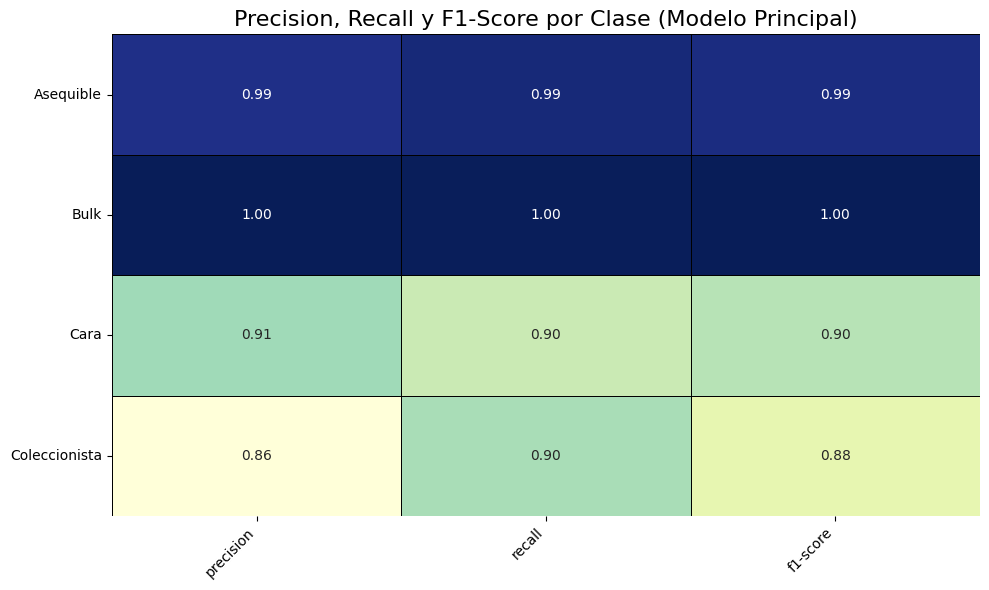


4. Resumen de Aciertos y Fallos del Modelo Principal:
Predicciones Correctas: 3673 / 3693 (99.46%)
Predicciones Incorrectas: 20 / 3693 (0.54%)

Visualizaciones de Resultados del Clasificador Finalizadas.


In [20]:
# @title Celda 4: Visualización de Resultados del Modelo de Clasificación

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import pandas as pd

print("\n--- Generando Visualizaciones de Resultados del Clasificador ---")

# Verificar si los resultados del entrenamiento están disponibles (estas variables deberían estar definidas por Celda 3)
if 'y_test_clf' not in locals() or 'y_pred_clf' not in locals() or 'lgbm_classifier_model' not in locals():
    # Este mensaje se activará si Celda 3 NO SE EJECUTÓ justo antes, o si el kernel se reinició
    print("ERROR: Los resultados de entrenamiento (y_test_clf, y_pred_clf) o el modelo (`lgbm_classifier_model`) no están disponibles.")
    print("Por favor, asegúrate de ejecutar la Celda 3 (Preprocesamiento y Entrenamiento) COMPLETAMENTE justo antes de ejecutar esta celda.")
else:
    # 1. Gráfico de Matriz de Confusión
    print("\n1. Visualizando la Matriz de Confusión...")
    fig, ax = plt.subplots(figsize=(10, 8))

    # Asegúrate de que las clases se usen en el mismo orden que el modelo las predice/espera
    labels_order = lgbm_classifier_model.classes_ # El modelo guarda el orden de sus clases

    cm_display = ConfusionMatrixDisplay.from_predictions(
        y_test_clf, y_pred_clf,
        display_labels=labels_order,
        cmap=plt.cm.Blues,
        normalize=None, # None para mostrar conteos absolutos
        ax=ax
    )
    ax.set_title('Matriz de Confusión (Conteo Absoluto)', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Matriz de Confusión Normalizada por fila (Recall)
    fig_norm, ax_norm = plt.subplots(figsize=(10, 8))
    ConfusionMatrixDisplay.from_predictions(
        y_test_clf, y_pred_clf,
        display_labels=labels_order,
        cmap=plt.cm.Greens,
        normalize='true', # Normaliza por fila (recall) para ver las proporciones de acierto por clase real
        ax=ax_norm
    )
    ax_norm.set_title('Matriz de Confusión (Recall - Proporción por Clase Verdadera)', fontsize=16)
    plt.tight_layout()
    plt.show()

    # 2. Conteo de Predicciones por Clase (Barras)
    print("\n2. Visualizando el Conteo de Predicciones por Clase (Reales vs. Predichas)...")
    plt.figure(figsize=(12, 6))

    results_df_temp = pd.DataFrame({'Real': y_test_clf, 'Predicha': y_pred_clf})

    # Conteo de valores reales y predichos, ordenando por el mismo `labels_order` para consistencia
    real_counts = results_df_temp['Real'].value_counts().reindex(labels_order, fill_value=0)
    pred_counts = results_df_temp['Predicha'].value_counts().reindex(labels_order, fill_value=0)

    # Unir para graficar lado a lado
    counts_combined = pd.DataFrame({'Real': real_counts, 'Predicha': pred_counts})
    counts_combined.plot(kind='bar', figsize=(10, 6), cmap='Paired', edgecolor='black')
    plt.title('Conteo de Cartas por Clase: Reales vs. Predichas', fontsize=16)
    plt.xlabel('Categoría de Precio', fontsize=12)
    plt.ylabel('Número de Cartas', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # 3. Reporte de Clasificación (con seaborn heatmap opcional para F1/Precision/Recall)
    print("\n3. Mostrando el Reporte de Clasificación Detallado del modelo principal:")
    # Se usa zero_division=0 para evitar warnings si alguna clase no tiene predicciones/true
    report_dict = classification_report(y_test_clf, y_pred_clf, target_names=labels_order, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report_dict).transpose()
    print(report_df.to_string())

    # Heatmap de las métricas clave (precision, recall, f1-score)
    plt.figure(figsize=(10, 6))
    # Excluye 'accuracy', 'macro avg', 'weighted avg' para solo mostrar por clase individual
    sns.heatmap(report_df.loc[labels_order, ['precision', 'recall', 'f1-score']], # Asegurarse de ordenar por labels_order
                annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5, linecolor='black', cbar=False)
    plt.title('Precision, Recall y F1-Score por Clase (Modelo Principal)', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()

    # 4. Resumen de Aciertos y Fallos
    print("\n4. Resumen de Aciertos y Fallos del Modelo Principal:")
    correct_predictions = (y_test_clf == y_pred_clf).sum()
    incorrect_predictions = (y_test_clf != y_pred_clf).sum()
    total_predictions = len(y_test_clf)

    print(f"Predicciones Correctas: {correct_predictions} / {total_predictions} ({correct_predictions/total_predictions:.2%})")
    print(f"Predicciones Incorrectas: {incorrect_predictions} / {total_predictions} ({incorrect_predictions/total_predictions:.2%})")

    # Opcional: Mostrar algunas predicciones incorrectas si se desea (requiere los IDs originales)
    # Para hacer esto, X_test_clf necesitaría tener los IDs originales mapeados,
    # lo cual es más complejo porque X_classifier_final es un array numpy de features procesadas.
    # Si quieres implementar esto, el train_test_split tendría que incluir la columna ID del dataframe original
    # para poder correlacionar los fallos con las cartas específicas. Por ahora, nos quedamos con el resumen.

print("\nVisualizaciones de Resultados del Clasificador Finalizadas.")